In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import larch
import os
import gzip
import transportation_tutorials as tt

In [2]:
larch.__version__

'5.7.0'

# Practical Mode Choice

The MTC sample dataset and models used here are the same used in the [Self Instructing Course in Mode Choice Modeling: Multinomial and Nested Logit Models](http://www.caee.utexas.edu/prof/bhat/courses/lm_draft_060131final-060630.pdf). Readers are invited to visit that text for a much more in-depth review of why the models shown here
are developed, including deeper reviews of the underlying choice theory and the development of discrete 
choice model specifications.  What follows here is focused instead on how to execute this modeling workflow
using Python and Larch.

The dataset used to demonstrate these approaches is old and small, but we work with this San Francisco 
Bay Area work mode choice data set to ensure consistency with the Self Instructing Course.

> The San Francisco Bay Area work mode choice data set comprises 5029 home-to-work commute trips in the
> San Francisco Bay Area. The data is drawn from the San Francisco Bay Area Household Travel Survey
> conducted by the Metropolitan Transportation Commission (MTC) in the spring and fall of 1990. This
> survey included a one day travel diary for each household member older than five years and detailed
> individual and household socio-demographic information.

To load this data, we can use the usual pandas `read_csv` tool.

In [3]:
df = pd.read_csv("example-data/MTCwork.csv.gz", index_col=['casenum','altnum'])
df.head(12)

chose   ivtt  ovtt  tottime  totcost  hhid  perid  numalts  \
casenum altnum                                                               
1       1           1  13.38   2.0    15.38    70.63     2      1        2   
        2           0  18.38   2.0    20.38    35.32     2      1        2   
        3           0  20.38   2.0    22.38    20.18     2      1        2   
        4           0  25.90  15.2    41.10   115.64     2      1        2   
        5           0  40.50   2.0    42.50     0.00     2      1        2   
2       1           0  29.92  10.0    39.92   390.81     3      1        2   
        2           0  34.92  10.0    44.92   195.40     3      1        2   
        3           0  21.92  10.0    31.92    97.97     3      1        2   
        4           1  22.96  14.2    37.16   185.00     3      1        2   
        5           0  58.95  10.0    68.95     0.00     3      1        2   
3       1           1   8.60   6.0    14.60    37.76     5      1        2   
        2           0  13.60   6.0    19.60    18.88     5      1        2   

                 dist  wkzone  ...  numadlt  nmlt5  nm5to11  nm12to16  wkccbd  \
casenum altnum                 ...                                              
1       1        7.69     664  ...        1      0        0         0       0   
        2        7.69     664  ...        1      0        0         0       0   
        3        7.69     664  ...        1      0        0         0       0   
        4        7.69     664  ...        1      0        0         0       0   
        5        7.69     664  ...        1      0        0         0       0   
2       1       11.62     738  ...        1      0        0         0       1   
        2       11.62     738  ...        1      0        0         0       1   
        3       11.62     738  ...        1      0        0         0       1   
        4       11.62     738  ...        1      0        0         0       1   
        5       11.62     738  ...        1      0        0         0       1   
3       1        4.10     696  ...        3      2        0         0       0   
        2        4.10     696  ...        3      2        0         0       0   

                wknccbd  corredis  vehbywrk  vocc  wgt  
casenum altnum                                          
1       1             0         0      4.00     1    1  
        2             0         0      4.00     1    1  
        3             0         0      4.00     1    1  
        4             0         0      4.00     1    1  
        5             0         0      4.00     1    1  
2       1             0         1      1.00     0    1  
        2             0         1      1.00     0    1  
        3             0         1      1.00     0    1  
        4             0         1      1.00     0    1  
        5             0         1      1.00     0    1  
3       1             1         0      0.33     1    1  
        2             1         0      0.33     1    1  

[12 rows x 36 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22033 entries, (1, 1) to (5029, 6)
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   chose     22033 non-null  int64  
 1   ivtt      22033 non-null  float64
 2   ovtt      22033 non-null  float64
 3   tottime   22033 non-null  float64
 4   totcost   22033 non-null  float64
 5   hhid      22033 non-null  int64  
 6   perid     22033 non-null  int64  
 7   numalts   22033 non-null  int64  
 8   dist      22033 non-null  float64
 9   wkzone    22033 non-null  int64  
 10  hmzone    22033 non-null  int64  
 11  rspopden  22033 non-null  float64
 12  rsempden  22033 non-null  float64
 13  wkpopden  22033 non-null  float64
 14  wkempden  22033 non-null  float64
 15  vehavdum  22033 non-null  int64  
 16  femdum    22033 non-null  int64  
 17  age       22033 non-null  int64  
 18  drlicdum  22033 non-null  int64  
 19  noncadum  22033 non-null  int64  
 20  numveh    22033 non

We can use a specialized data pre-processor built into Larch to convert this
single table of data into a few related tables in the appropriate formats.
This requires identifying what the "choice" column is in this data.  We'll
let the pre-processor automatically infer all of the possible alternatives,
and use the `crack` argument to tell it to seperate the data into distinct
`idca` and `idco` tables as appropriate.

In [5]:
df

chose   ivtt  ovtt  tottime  totcost  hhid  perid  numalts  \
casenum altnum                                                               
1       1           1  13.38   2.0    15.38    70.63     2      1        2   
        2           0  18.38   2.0    20.38    35.32     2      1        2   
        3           0  20.38   2.0    22.38    20.18     2      1        2   
        4           0  25.90  15.2    41.10   115.64     2      1        2   
        5           0  40.50   2.0    42.50     0.00     2      1        2   
...               ...    ...   ...      ...      ...   ...    ...      ...   
5029    2           0  11.54   4.5    16.04     5.71  9438      1        2   
        3           0  13.54   4.5    18.04     3.26  9438      1        2   
        4           0   1.59  16.0    17.59    75.00  9438      1        2   
        5           0   6.55   4.5    11.05     0.00  9438      1        2   
        6           0   0.00   0.0    19.10     0.00  9438      1        2   

                dist  wkzone  ...  numadlt  nmlt5  nm5to11  nm12to16  wkccbd  \
casenum altnum                ...                                              
1       1       7.69     664  ...        1      0        0         0       0   
        2       7.69     664  ...        1      0        0         0       0   
        3       7.69     664  ...        1      0        0         0       0   
        4       7.69     664  ...        1      0        0         0       0   
        5       7.69     664  ...        1      0        0         0       0   
...              ...     ...  ...      ...    ...      ...       ...     ...   
5029    2       0.73    1021  ...        1      2        2         0       0   
        3       0.73    1021  ...        1      2        2         0       0   
        4       0.73    1021  ...        1      2        2         0       0   
        5       0.73    1021  ...        1      2        2         0       0   
        6       0.73    1021  ...        1      2        2         0       0   

                wknccbd  corredis  vehbywrk  vocc  wgt  
casenum altnum                                          
1       1             0         0       4.0     1    1  
        2             0         0       4.0     1    1  
        3             0         0       4.0     1    1  
        4             0         0       4.0     1    1  
        5             0         0       4.0     1    1  
...                 ...       ...       ...   ...  ...  
5029    2             0         0       3.0     1    1  
        3             0         0       3.0     1    1  
        4             0         0       3.0     1    1  
        5             0         0       3.0     1    1  
        6             0         0       3.0     1    1  

[22033 rows x 36 columns]

In [6]:
d = larch.DataFrames(
    df, 
    ch='chose', 
    crack=True,
    alt_names=['DA', 'SR2', 'SR3+', 'Transit', 'Bike', 'Walk'],
    alt_codes=[1, 2, 3, 4, 5, 6],
)
d.info()

larch.DataFrames:  (not computation-ready)
  n_cases: 5029
  n_alts: 6
  data_ce: 5 variables, 22033 rows
  data_co: 31 variables
  data_av: <populated>
  data_ch: chose


By setting `crack` to `True`, Larch automatically analyzed the data to find variables that do not vary within
cases, and transformed those into `idco` format variables.  If you would prefer that
Larch not do this you can omit this argument or set it to False.  This is particularly
important for larger datasets (the data sample included is only a tiny extract of the data
that might be available for this kind of model), as breaking the data into seperate `idca` and `idco` parts is
a relatively expensive operation, and it is not actually required for most model structures.



If we want a more detailed look at the data, we can specify `verbose=True` 
when calling the `info` method on the DataFrames we've set up.

In [7]:
d.info(verbose=True)

larch.DataFrames:  (not computation-ready)
  n_cases: 5029
  n_alts: 6
  data_ce: 22033 rows
    - chose   (22033 non-null int64)
    - ivtt    (22033 non-null float64)
    - ovtt    (22033 non-null float64)
    - tottime (22033 non-null float64)
    - totcost (22033 non-null float64)
  data_co:
    - hhid     (5029 non-null int64)
    - perid    (5029 non-null int64)
    - numalts  (5029 non-null int64)
    - dist     (5029 non-null float64)
    - wkzone   (5029 non-null int64)
    - hmzone   (5029 non-null int64)
    - rspopden (5029 non-null float64)
    - rsempden (5029 non-null float64)
    - wkpopden (5029 non-null float64)
    - wkempden (5029 non-null float64)
    - vehavdum (5029 non-null int64)
    - femdum   (5029 non-null int64)
    - age      (5029 non-null int64)
    - drlicdum (5029 non-null int64)
    - noncadum (5029 non-null int64)
    - numveh   (5029 non-null int64)
    - hhsize   (5029 non-null int64)
    - hhinc    (5029 non-null float64)
    - famtype  (5029 non-

You might notice that the choice and availability information in the data
receives special treatment in the `larch.DataFrames` structure.  These two
features in the data are seperated from the rest and stored in their own
special `pandas.DataFrame` objects.

In [8]:
d.data_ch.head()

altnum,1,2,3,4,5,6
casenum,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0


The availability data in this example has been inferred from the presence
or absence of rows in the original csv data.

In [9]:
d.data_av.head()

,1,2,3,4,5,6
_caseid_,,,,,,
1,1,1,1,1,1,0
2,1,1,1,1,1,0
3,1,1,1,1,0,0
4,1,1,1,1,0,0
5,0,1,1,1,1,0


Once we have loaded the data like this, it is useful to make a review of the data from a statistical
point of view, to make sure that it conforms with our expectations.  One usful tool to do this is
with the `describe` method that's part of `pandas`, and can be used on any DataFrame.

In [10]:
d.data_co.describe()

,hhid,perid,numalts,dist,wkzone,hmzone,rspopden,rsempden,wkpopden,wkempden,...,numadlt,nmlt5,nm5to11,nm12to16,wkccbd,wknccbd,corredis,vehbywrk,vocc,wgt
count,5029.000000,5029.000000,5029.0,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,...,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.0
mean,4682.154703,1.586598,2.0,11.730147,554.781666,486.712667,22.628196,35.332877,57.210072,79.318789,...,2.260091,0.208391,0.194671,0.152913,0.121893,0.167230,0.158680,1.334498,1.055478,1.0
std,2698.243528,0.796214,0.0,11.435474,327.061505,344.231497,85.434143,69.458563,262.055620,166.364233,...,0.984142,0.565447,0.530010,0.444495,0.327195,0.373218,0.365413,0.805854,0.770054,0.0
min,2.000000,1.000000,2.0,0.260000,1.000000,1.000000,0.000000,0.080000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2368.000000,1.000000,2.0,3.430000,250.000000,200.000000,10.130000,9.710000,11.130000,13.260000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
50%,4734.000000,1.000000,2.0,7.670000,556.000000,449.000000,15.070000,18.900000,17.390000,23.970000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
75%,6991.000000,2.000000,2.0,16.190000,839.000000,796.000000,23.760000,32.170000,36.000000,46.230000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000,1.0
max,9438.000000,8.000000,2.0,101.470000,1099.000000,1099.000000,5802.000000,1068.000000,7449.000000,1068.000000,...,10.000000,8.000000,5.000000,4.000000,1.000000,1.000000,1.000000,8.000000,9.000000,1.0


An additional tool that is provided once Larch is loaded is the `statistics` measure, which computes a 
different set of statistics that might be more useful for reviewing data typically used in
discrete choice modeling.

In [11]:
d.data_co.statistics()

n  minimum  maximum   median  \
hhid      5029     2.00  9438.00  4734.00   
perid     5029     1.00     8.00     1.00   
numalts   5029     2.00     2.00     2.00   
dist      5029     0.26   101.47     7.67   
wkzone    5029     1.00  1099.00   556.00   
hmzone    5029     1.00  1099.00   449.00   
rspopden  5029     0.00  5802.00    15.07   
rsempden  5029     0.08  1068.00    18.90   
wkpopden  5029     0.00  7449.00    17.39   
wkempden  5029     0.00  1068.00    23.97   
vehavdum  5029     0.00     1.00     1.00   
femdum    5029     0.00     1.00     0.00   
age       5029    18.00    83.00    38.00   
drlicdum  5029     0.00     1.00     1.00   
noncadum  5029     0.00     1.00     0.00   
numveh    5029     0.00    14.00     2.00   
hhsize    5029     1.00    13.00     2.00   
hhinc     5029     3.00   145.00    55.00   
famtype   5029     1.00    99.00     4.00   
hhowndum  5029     0.00     1.00     1.00   
numemphh  5029     1.00     8.00     2.00   
numadlt   5029     1.00    10.00     2.00   
nmlt5     5029     0.00     8.00     0.00   
nm5to11   5029     0.00     5.00     0.00   
nm12to16  5029     0.00     4.00     0.00   
wkccbd    5029     0.00     1.00     0.00   
wknccbd   5029     0.00     1.00     0.00   
corredis  5029     0.00     1.00     0.00   
vehbywrk  5029     0.00     8.00     1.00   
vocc      5029     0.00     9.00     1.00   
wgt       5029     1.00     1.00     1.00   

                                                  histogram         mean  \
hhid      [[[<Element '{http://www.w3.org/1999/02/22-rdf...  4682.154703   
perid     [[[<Element '{http://www.w3.org/1999/02/22-rdf...     1.586598   
numalts   [[[<Element '{http://www.w3.org/1999/02/22-rdf...     2.000000   
dist      [[[<Element '{http://www.w3.org/1999/02/22-rdf...    11.730147   
wkzone    [[[<Element '{http://www.w3.org/1999/02/22-rdf...   554.781666   
hmzone    [[[<Element '{http://www.w3.org/1999/02/22-rdf...   486.712667   
rspopden  [[[<Element '{http://www.w3.org/1999/02/22-rdf...    22.628196   
rsempden  [[[<Element '{http://www.w3.org/1999/02/22-rdf...    35.332877   
wkpopden  [[[<Element '{http://www.w3.org/1999/02/22-rdf...    57.210072   
wkempden  [[[<Element '{http://www.w3.org/1999/02/22-rdf...    79.318789   
vehavdum  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.968185   
femdum    [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.434878   
age       [[[<Element '{http://www.w3.org/1999/02/22-rdf...    39.055478   
drlicdum  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.960430   
noncadum  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.276993   
numveh    [[[<Element '{http://www.w3.org/1999/02/22-rdf...     2.325512   
hhsize    [[[<Element '{http://www.w3.org/1999/02/22-rdf...     2.816067   
hhinc     [[[<Element '{http://www.w3.org/1999/02/22-rdf...    58.457347   
famtype   [[[<Element '{http://www.w3.org/1999/02/22-rdf...    11.895009   
hhowndum  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.625771   
numemphh  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     1.879897   
numadlt   [[[<Element '{http://www.w3.org/1999/02/22-rdf...     2.260091   
nmlt5                                                  None     0.208391   
nm5to11                                                None     0.194671   
nm12to16  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.152913   
wkccbd    [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.121893   
wknccbd   [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.167230   
corredis  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     0.158680   
vehbywrk  [[[<Element '{http://www.w3.org/1999/02/22-rdf...     1.334498   
vocc      [[[<Element '{http://www.w3.org/1999/02/22-rdf...     1.055478   
wgt       [[[<Element '{http://www.w3.org/1999/02/22-rdf...     1.000000   

                stdev  zeros  positives  negatives  nonzero_minimum  \
hhid      2697.975246      0       5029          0             2.00 

We can also get a larger view of any of these rows by running statistics on a single pandas.Series (i.e. one column from a DataFrame):

In [12]:
d.data_co['dist'].statistics()

┣               n: 5029
┣         minimum: 0.26
┣         maximum: 101.47
┣          median: 7.67
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 11.73014714655001
┣           stdev: 11.434337460208594
┣           zeros: 0
┣       positives: 5029
┣       negatives: 0
┣ nonzero_minimum: 0.26
┣ nonzero_maximum: 101.47
┣    nonzero_mean: 11.73014714655001
┣   nonzero_stdev: 11.434337460208594

## Model Design

To demostrate the model design process, we'll follow the [Self Instructing Course](http://www.caee.utexas.edu/prof/bhat/courses/lm_draft_060131final-060630.pdf) and begin
with a simple model.  To do this with Larch, we'll create a `Model` based on the 
`DataFrames` we created above.

In [13]:
m1 = larch.Model(dataservice=d)

We'll want to write a utility function for each alternative that includes

- Alternative specific constants (ASCs)
- Most important demographic variables: income
- Essential level of service variables: travel time and travel cost

You may recall from the derivation of the MNL model that *only the differences
in utility* are relevant.  For the constants, and for demographic measures such
as household income, the explanatory data does not vary across the alternatives,
therefore the parameters must do so.

The split of the data we observed above helps reinforce this: household income
(`"hhinc"`) appears in the `idco` format data -- implying that it does not 
vary based on the alternative. 

So, we'll want to write a utility function that looks something like this:

$$
U_{i} = \beta_{const,i} + \beta_{income,i} Income + \beta_{time} Time + \beta_{cost} Cost + \varepsilon_i
$$

or, because in model estimation we're only going to compute the systematic
utility and let our tools manage the random utility:

$$
V_{i} = \beta_{const,i} + \beta_{income,i} Income + \beta_{time} Time + \beta_{cost} Cost 
$$

You'll note that the constant and the income terms have parameters indexed both by
the type of parameter and the alternative, while the time and cost terms have 
parameters indexed only by the type of parameter.  In Larch, we'll seperate these two
kinds of parameters into seperate parts of the utility function.

For the part of utility using `idco` data, we'll want to write seperate utility
functions with unique parameters for each alternative.  We'll do that using the
`utility_co` attribute of the `Model`, and we'll write out linear-in-parmeters
functions using special classes imported from Larch: `P` to refer to parameters 
and `X` to refer to data.

In [14]:
from larch import P, X


m1.utility_co[2] = P("ASC_SR2")  + P("hhinc#2") * X("log(hhinc)")
m1.utility_co[3] = P("ASC_SR3P") + P("hhinc#3") * X("hhinc")
m1.utility_co[4] = P("ASC_TRAN") + P("hhinc#4") * X("hhinc")
m1.utility_co[5] = P("ASC_BIKE") + P("hhinc#5") * X("hhinc")
m1.utility_co[6] = P("ASC_WALK") + P("hhinc#6") * X("hhinc")

Notice that we don't write a function for alternative 1.  That's because one alternative needs to be the reference point.

For the part of utility using `idca` data, we'll want to write a single utility
function for all alternatives.  We'll do that using the
`utility_ca` attribute of the `Model`, again writing out linear-in-parmeters
functions using the `P` and `X` classes, or the shorthand `PX` class, which
implies multipling a parameter and data with the same name.

In [15]:
from larch import PX

m1.utility_ca = PX("tottime") + PX("totcost")
m1.utility_ca = P("tottime") * X("tottime") + P("totcost") * X("totcost") # same!

In [16]:
d.data_ce.eval("tottime * 4.34 / totcost")

_caseid_  _altid_
1         1           0.945055
          2           2.504224
          3           4.813142
          4           1.542494
          5                inf
                       ...    
5029      2          12.191524
          3          24.016442
          4           1.017875
          5                inf
          6                inf
Length: 22033, dtype: float64

We'll add a title to this model, which will make reporting result later more convenient.

In [17]:
m1.title = "Model 1"

Now we're ready to estimate the parameters from our model.  We can use the
`estimate` method to do this, which will run an appropriate likelihood maximization routine to find the 
best parameter values for the model.

In [18]:
m1.estimate();

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
ASC_BIKE,-2.374327,0.0,0.0,-inf,inf,0,,-2.374327
ASC_SR2,-1.875818,0.0,0.0,-inf,inf,0,,-1.875818
ASC_SR3P,-3.726269,0.0,0.0,-inf,inf,0,,-3.726269
ASC_TRAN,-0.668808,0.0,0.0,-inf,inf,0,,-0.668808
ASC_WALK,-0.202916,0.0,0.0,-inf,inf,0,,-0.202916
hhinc#2,-0.109735,0.0,0.0,-inf,inf,0,,-0.109735
hhinc#3,0.000386,0.0,0.0,-inf,inf,0,,0.000386
hhinc#4,-0.005302,0.0,0.0,-inf,inf,0,,-0.005302
hhinc#5,-0.012834,0.0,0.0,-inf,inf,0,,-0.012834
hhinc#6,-0.009736,0.0,0.0,-inf,inf,0,,-0.009736


We can review the results of the parameter estimation in the `parameter_summary`: 

In [19]:
m1.parameter_summary()

,Value,Std Err,t Stat,Signif,Null Value
ASC_BIKE,-2.37,0.305,-7.78,***,0.00
ASC_SR2,-1.88,0.320,-5.87,***,0.00
ASC_SR3P,-3.73,0.178,-20.94,***,0.00
ASC_TRAN,-0.669,0.133,-5.03,***,0.00
ASC_WALK,-0.203,0.195,-1.04,,0.00
hhinc#2,-0.110,0.0809,-1.36,,0.00
hhinc#3,0.000386,0.00254,0.15,,0.00
hhinc#4,-0.00530,0.00184,-2.89,**,0.00
hhinc#5,-0.0128,0.00534,-2.41,*,0.00
hhinc#6,-0.00974,0.00304,-3.20,**,0.00


We'll also want to have the log likelihood of the null model.

In [20]:
m1.loglike_null()

-7309.600971749626

Note this "null" value isn't necessarily the same as a "no information" log likelihood,
as although we're not using any model parameters, we are using information about alternative
availability in the calculation.  If we want a truly "no information" log likelihood, we
can simply take the log of the inverse of the number of alternatives that might be available
for each decision maker, and multiply by the number of observations:

In [21]:
5029 * np.log(1/6)

-9010.758370747888

This version of the "no information" log likelihood isn't really useful for statistical 
comparison, as we're assuming the alternative availability is a fundamental part of the 
data itself, just like the fact that there are 5029 observations.  But from a pure theory
point of view, we know that when some alternatives are not available for some decision makers,
the null log likelihood must be better than this value.

We can also construct constants only model.

In [22]:
m_c = larch.Model(dataservice=d)
m_c.utility_co[2] = P("ASC_SR2")  
m_c.utility_co[3] = P("ASC_SR3P") 
m_c.utility_co[4] = P("ASC_TRAN") 
m_c.utility_co[5] = P("ASC_BIKE") 
m_c.utility_co[6] = P("ASC_WALK") 
m_c.title = "Constants Only"
m_c.estimate();

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
ASC_BIKE,-3.334602,0.0,0.0,-inf,inf,0,,-3.334602
ASC_SR2,-2.136724,0.0,0.0,-inf,inf,0,,-2.136724
ASC_SR3P,-3.303312,0.0,0.0,-inf,inf,0,,-3.303312
ASC_TRAN,-1.950529,0.0,0.0,-inf,inf,0,,-1.950529
ASC_WALK,-2.040437,0.0,0.0,-inf,inf,0,,-2.040437


In [23]:
m_c.parameter_summary()

,Value,Std Err,t Stat,Signif,Null Value
ASC_BIKE,-3.33,0.145,-23.07,***,0.00
ASC_SR2,-2.14,0.0484,-44.12,***,0.00
ASC_SR3P,-3.30,0.0814,-40.59,***,0.00
ASC_TRAN,-1.95,0.0505,-38.59,***,0.00
ASC_WALK,-2.04,0.0854,-23.90,***,0.00


In [24]:
from larch.util.summary import joint_parameter_summary
from larch.util.excel import ExcelWriter

In [26]:
xl = ExcelWriter('./tmp/mode-choice.xlsx')
# xl = ExcelWriter('./mode-choice.xlsx')

In [27]:
xl.add_content_tab(
    joint_parameter_summary([m1, m_c], bases=[m_c]), 
    sheetname='Step 1',
)

Model 1         Constants Only        
                                      Param  t-Stat          Param  t-Stat
Category       Parameter                                                  
Parameters     ASC_BIKE               -2.37   -7.78          -3.33  -23.07
               ASC_SR2                -1.88   -5.87          -2.14  -44.12
               ASC_SR3P               -3.73  -20.94          -3.30  -40.59
               ASC_TRAN              -0.669   -5.03          -1.95  -38.59
               ASC_WALK              -0.203   -1.04          -2.04  -23.90
               hhinc#2               -0.110   -1.36                       
               hhinc#3             0.000386    0.15                       
               hhinc#4             -0.00530   -2.89                       
               hhinc#5              -0.0128   -2.41                       
               hhinc#6             -0.00974   -3.20                       
               totcost             -0.00492  -20.60                       
               tottime              -0.0513  -16.57                       
----           ----                    ----    ----           ----    ----
Log Likelihood Converged          -3,626.27              -4,132.92        
               Null               -7,309.60                               
               Constants Only     -4,132.92              -4,132.92        
Rho Squared    vs Null               0.5039                               
               vs Constants Only     0.1226                 0.0000

### Income Refinements

Let's look at some plausible specifications for income refinements.

- Model 2: The effect of income relative to drive alone is the same for the two shared ride modes (shared ride 2 and shared ride 3+)

- Model 3: The effect of income relative to drive alone is the same for both shared ride modes and transit but is different for the other modes.

- Model 4: The effect of income on all the automobile modes (drive alone, shared ride 2, and shared ride 3+) is the same.

There are two ways to make sure that the effect of income relative to 
drive alone is at least as negative for SR3+ as it is for SR2: 

- make them actually the same parameter, or 
- impose a constraint that the parameter for SR3+ must be less than or equal to the parameter for SR2.

The first way is simpler, generally faster to estimate, and more
numerically stable.  The second method, on the other hand, allows
the constraint to unwind automatically if doing so would be 
valuable as we further refine the model specification.

In [28]:
# Make them the same parameter
m2 = m1.copy()
m2.title = "Model 2"
m2.utility_co[2] = P("ASC_SR2")  + P("hhinc#23") * X("hhinc")
m2.utility_co[3] = P("ASC_SR3P") + P("hhinc#23") * X("hhinc")
m2.remove_unused_parameters(verbose=True) # removes the old #2 and #3 parameters now unused
r2=m2.estimate(quiet=True);

dropped 2 parameters: hhinc#2, hhinc#3
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [29]:
# Impose a constraint directly
m2a = m1.copy()
m2a.title = "Model 2.1"
m2a.constraints.append("hhinc#3 <= hhinc#2")
m2a.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\model\optimization.py:308: UserWarning: slsqp may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [30]:
joint_parameter_summary([m2, m2a])

Model 2          Model 2.1        
                              Param  t-Stat      Param  t-Stat
Category       Parameter                                      
Parameters     ASC_BIKE       -2.38   -7.81      -2.40   -7.90
               ASC_SR2        -2.21  -22.66      -2.31  -41.52
               ASC_SR3P       -3.61  -29.30      -3.75  -21.18
               ASC_TRAN      -0.670   -5.05     -0.701   -5.35
               ASC_WALK      -0.207   -1.07     -0.232   -1.20
               hhinc#2                        0.000728    0.29
               hhinc#23    -0.00158   -1.13                   
               hhinc#3                        0.000728    0.29
               hhinc#4     -0.00532   -2.91   -0.00480   -2.68
               hhinc#5      -0.0128   -2.41    -0.0124   -2.34
               hhinc#6     -0.00968   -3.19   -0.00930   -3.08
               totcost     -0.00492  -20.61   -0.00491  -20.59
               tottime      -0.0513  -16.57    -0.0513  -16.56
----           ----            ----    ----       ----    ----
Log Likelihood Converged  -3,626.59          -3,627.19        
               Null       -7,309.60          -7,309.60        
Rho Squared    vs Null       0.5039             0.5038

In [31]:
m3 = m1.copy()
m3.title = "Model 3"
m3.utility_co[2] = P("ASC_SR2")  + P("hhinc#234") * X("hhinc")
m3.utility_co[3] = P("ASC_SR3P") + P("hhinc#234") * X("hhinc")
m3.utility_co[4] = P("ASC_TRAN") + P("hhinc#234") * X("hhinc")
m3.remove_unused_parameters() # removes the old parameters
m3.estimate(quiet=True);

dropped 3 parameters: hhinc#2, hhinc#3, hhinc#4
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [32]:
m4 = m1.copy()
m4.title = "Model 4"
m4.utility_co[2] = P("ASC_SR2")  
m4.utility_co[3] = P("ASC_SR3P") 
m4.remove_unused_parameters() # removes the old #2 and #3 parameters
m4.estimate(quiet=True);

dropped 2 parameters: hhinc#2, hhinc#3
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [33]:
xl.add_content_tab(
    joint_parameter_summary([m1, m2, m3, m4], bases=[m_c]),
    sheetname='Step 2',
)

Model 1            Model 2          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
Parameters     ASC_BIKE               -2.37   -7.78      -2.38   -7.81   
               ASC_SR2                -1.88   -5.87      -2.21  -22.66   
               ASC_SR3P               -3.73  -20.94      -3.61  -29.30   
               ASC_TRAN              -0.669   -5.03     -0.670   -5.05   
               ASC_WALK              -0.203   -1.04     -0.207   -1.07   
               hhinc#2               -0.110   -1.36                      
               hhinc#23                               -0.00158   -1.13   
               hhinc#234                                                 
               hhinc#3             0.000386    0.15                      
               hhinc#4             -0.00530   -2.89   -0.00532   -2.91   
               hhinc#5              -0.0128   -2.41    -0.0128   -2.41   
               hhinc#6             -0.00974   -3.20   -0.00968   -3.19   
               totcost             -0.00492  -20.60   -0.00492  -20.61   
               tottime              -0.0513  -16.57    -0.0513  -16.57   
----           ----                    ----    ----       ----    ----   
Log Likelihood Converged          -3,626.27          -3,626.59           
               Null               -7,309.60          -7,309.60           
               Constants Only     -4,132.92          -4,132.92           
Rho Squared    vs Null               0.5039             0.5039           
               vs Constants Only     0.1226             0.1225           

                                    Model 3            Model 4          
                                      Param  t-Stat      Param  t-Stat  
Category       Parameter                                                
Parameters     ASC_BIKE               -2.39   -7.85      -2.40   -7.89  
               ASC_SR2                -2.14  -24.18      -2.30  -42.14  
               ASC_SR3P               -3.53  -30.64      -3.70  -39.81  
               ASC_TRAN              -0.799   -7.11     -0.698   -5.35  
               ASC_WALK              -0.230   -1.19     -0.229   -1.19  
               hhinc#2                                                  
               hhinc#23                                                 
               hhinc#234           -0.00287   -2.35                     
               hhinc#3                                                  
               hhinc#4                                -0.00486   -2.73  
               hhinc#5              -0.0125   -2.35    -0.0125   -2.35  
               hhinc#6             -0.00925   -3.07   -0.00934   -3.10  
               totcost             -0.00490  -20.57   -0.00491  -20.61  
               tottime              -0.0514  -16.61    -0.0513  -16.56  
----           ----                    ----    ----       ----    ----  
Log Likelihood Converged          -3,628.29          -3,627.23          
               Null               -7,309.60          -7,309.60          
               Constants Only     -4,132.92          -4,132.92          
Rho Squared    vs Null               0.5036             0.5038          
               vs Constants Only     0.1221             0.1224

Let's review some likelihood ratio tests.

In [34]:
from scipy.stats import chi2

def LRT(model_u, model_r, deg_free):
    stat = 2*(model_u.loglike() - model_r.loglike())
    p = chi2(df=deg_free).sf(stat)
    return f"{stat:.3f}, p={p:.3f}"

In [35]:
LRT(m1,m2,1)

'0.646, p=0.422'

In [36]:
LRT(m1,m3,2)

'4.037, p=0.133'

In [37]:
LRT(m1,m4,2)

'1.933, p=0.380'

In [38]:
LRT(m2,m4,1)

'1.288, p=0.256'

- The parameter estimates are consistent with expectations.
- All the parameters are significant except for shared ride income parameters in Model 2.
- Model 1 does not reject Models 2, 3, or 4.
- We choose Model 2 because it is most consistent with our hypotheses about
  the effect of income on preference between drive alone and shared ride and
  other modes.
- The small differences in goodness of fit among these models suggests that the
  income specification should be reconsidered before the final model specification is adopted.


### Alternative Travel Time Specifications

- Travel time specifications seek to relax constraints on the utility value of time. 
- We use statistical tests and calculate individuals' value of time judge the quality of models.

Some options on how to handle travel time:

- Disaggregate total time into OVT and IVT 
    - People are more sensitive to OVT than IVT
      (~2-5 times more sensitive) 
    - How should we classify walking?
- Disaggregate total time across non-motorized and motorized modes 
    - This distinction tends to work well in practice


Model 5 relaxes equality of motorized and non-motorized time (more negative, significant)

In [39]:
m5 = m2.copy()
m5.title = "Model 5"
m5.utility_ca = (
    + P('motor_time'   ) * X('tottime') * X('_altid_ in (1,2,3,4)') 
    + P('nonmotor_time') * X('tottime') * X('_altid_ in (5,6)'    ) 
    + PX('totcost')
)
m5.remove_unused_parameters() 
m5.estimate(quiet=True);

dropped 1 parameters: tottime
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


Model 6 disaggregates motorized modes into IVT and OVT

In [40]:
m6 = m2.copy()
m6.title = "Model 6"
m6.utility_ca = (
    + P('ivtt') * X('ivtt') * X('_altid_ in (1,2,3,4)') 
    + PX('ovtt') * X('_altid_ in (1,2,3,4)') 
    + P('nonmotor_time') * X('tottime') * X('_altid_ in (5,6)') 
    + PX('totcost')
)
m6.remove_unused_parameters()
m6.estimate(quiet=True);

dropped 1 parameters: tottime
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [41]:
xl.add_content_tab(
    joint_parameter_summary([m2, m5, m6], bases=[m_c]),
    sheetname='Step 3',
)

Model 2            Model 5          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
Parameters     ASC_BIKE               -2.38   -7.81      -1.84   -5.66   
               ASC_SR2                -2.21  -22.66      -2.26  -23.03   
               ASC_SR3P               -3.61  -29.30      -3.68  -29.61   
               ASC_TRAN              -0.670   -5.05     -0.852   -6.12   
               ASC_WALK              -0.207   -1.07      0.477    1.89   
               hhinc#23            -0.00158   -1.13   -0.00154   -1.10   
               hhinc#4             -0.00532   -2.91   -0.00545   -2.97   
               hhinc#5              -0.0128   -2.41    -0.0125   -2.37   
               hhinc#6             -0.00968   -3.19   -0.00952   -3.11   
               ivtt                                                      
               motor_time                              -0.0431  -12.29   
               nonmotor_time                           -0.0687  -12.90   
               ovtt                                                      
               totcost             -0.00492  -20.61   -0.00500  -20.68   
               tottime              -0.0513  -16.57                      
----           ----                    ----    ----       ----    ----   
Log Likelihood Converged          -3,626.59          -3,616.89           
               Null               -7,309.60          -7,309.60           
               Constants Only     -4,132.92          -4,132.92           
Rho Squared    vs Null               0.5039             0.5052           
               vs Constants Only     0.1225             0.1249           

                                    Model 6          
                                      Param  t-Stat  
Category       Parameter                             
Parameters     ASC_BIKE               -1.72   -5.32  
               ASC_SR2                -2.43  -24.14  
               ASC_SR3P               -3.88  -30.54  
               ASC_TRAN              -0.490   -3.29  
               ASC_WALK               0.409    1.62  
               hhinc#23            -0.00158   -1.14  
               hhinc#4             -0.00569   -3.07  
               hhinc#5              -0.0122   -2.33  
               hhinc#6             -0.00930   -3.05  
               ivtt                -0.00253   -0.41  
               motor_time                            
               nonmotor_time        -0.0632  -11.79  
               ovtt                 -0.0759  -12.96  
               totcost             -0.00480  -20.21  
               tottime                               
----           ----                    ----    ----  
Log Likelihood Converged          -3,588.04          
               Null               -7,309.60          
               Constants Only     -4,132.92          
Rho Squared    vs Null               0.5091          
               vs Constants Only     0.1318

In [42]:
LRT(m5,m2,1)

'19.392, p=0.000'

In [43]:
LRT(m6,m5,1)

'57.710, p=0.000'

In [44]:
LRT(m6,m2,2)

'77.102, p=0.000'

The parameter for `ivtt` in model 6 got quite small, and we may want to 
review the ratio of `ovtt` and `ivtt`.  We can access a bevy of information
about each parameter in the model by accessing it using the square bracket
operation:

In [45]:
m6['ivtt']

value            -0.002533
initvalue              0.0
nullvalue              0.0
minimum               -inf
maximum                inf
holdfast                 0
note                      
std_err           0.006195
t_stat           -0.408796
robust_std_err    0.006206
robust_t_stat    -0.408077
best             -0.002533
Name: ivtt, dtype: object

The very first item in this Series is the current value. We can use that
to evaluate simple mathematical expressions, such as the ratio between
two parameters.

In [46]:
m6['ovtt'].value / m6['ivtt'].value

29.985229796422264

The results show:

- The ratio OVT/IVT for motorized modes, 30, is quite high, probably too high -- it implies that travelers would prefer to spend an extra hour on the bus rather than spend 3 minutes waiting for the bus
- Value of time seems unreasonable for Model 6
- But Model 6 rejects Models 2 and 5 at very high significance level


### The Value of Travel Time

How do we calculate the value of time?

- The units of utility are utils. 
- Motorized IVT is measured in terms of minutes, and 
- Cost is measured in terms cents.

The estimated utility function implies a trade off:

In [47]:
print(f"1 minute of ivtt is worth {m6['ivtt'].value:.5f} utils")
print(f"1 cent of cost is worth {m6['totcost'].value:.5f} utils")

1 minute of ivtt is worth -0.00253 utils
1 cent of cost is worth -0.00480 utils


In [48]:
print(f"1 cent of cost is worth {(P.totcost/P.ivtt).value(m6):.2f} minutes of ivtt")
print(f"1 dollar of cost is worth {(P.totcost/P.ivtt*100).value(m6):.0f} minutes of ivtt")
print(f"1 dollar of cost is worth {(P.totcost/P.ivtt*100/60).value(m6):.2f} hours of ivtt")

1 cent of cost is worth 1.89 minutes of ivtt
1 dollar of cost is worth 189 minutes of ivtt
1 dollar of cost is worth 3.16 hours of ivtt


In [49]:
print(f"1 minute of ivtt is worth {m6['ivtt'].value/m6['totcost'].value:.5f} cents")
print(f"1 hour of ivtt is worth {m6['ivtt'].value/m6['totcost'].value*60:.5f} cents")
print(f"1 hour of ivtt is worth {m6['ivtt'].value/m6['totcost'].value*60/100:.5f} dollars")

1 minute of ivtt is worth 0.52777 cents
1 hour of ivtt is worth 31.66607 cents
1 hour of ivtt is worth 0.31666 dollars


In [50]:
print(f"1 hour of ovtt is worth {m6['ovtt'].value/m6['totcost'].value*60/100:.5f} dollars")

1 hour of ovtt is worth 9.49515 dollars


### Better Value of Time Specifications

To find a better specification, we will examine a range of different models in an attempt to find one which is both behaviorally sound and statistically supported.

What if we make out-of-vehicle time a function of trip distance?  A bit of OVTT 
is less noxious if you are traveling a long way, vs for a short trip.

However, as we see below, if we just divide OVTT by distance, we'll end up with
OVTT becoming less noxious than IVTT when the distance is long enough.

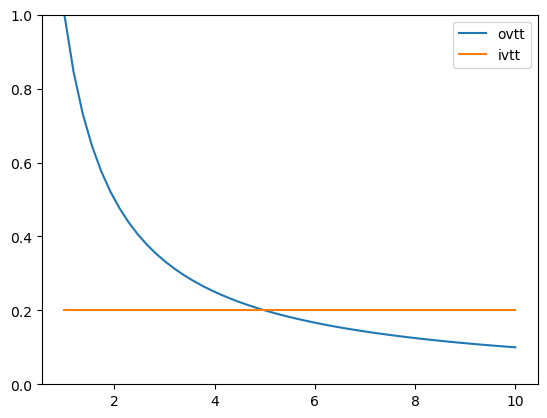

In [51]:
distance = np.linspace(1,10)
ovtt_effect = 1/distance
ivtt_effect = np.full_like(ovtt_effect, 0.2)
plt.plot(distance, ovtt_effect, label='ovtt')
plt.plot(distance, ivtt_effect, label='ivtt')
plt.ylim(0,1)
plt.legend();

An alternate solution: include OVTT divided by distance, plus *total* travel time.

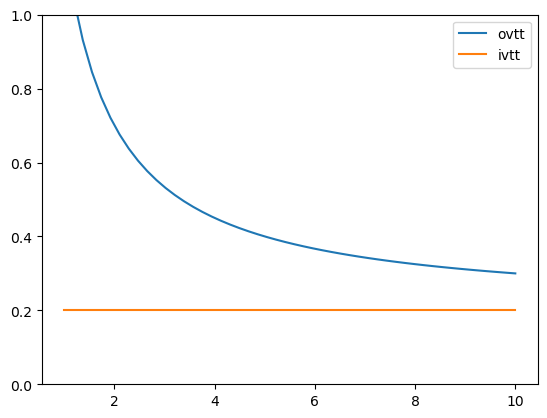

In [52]:
distance = np.linspace(1,10)
ivtt_effect = np.full_like(distance, 0.2)
ovtt_effect = 1/distance + ivtt_effect
plt.plot(distance, ovtt_effect, label='ovtt')
plt.plot(distance, ivtt_effect, label='ivtt')
plt.ylim(0,1)
plt.legend();

This is preferred because while both assume that the sensitivity of travelers to OVTT diminishes with the trip distance, the latter imposes the relationship that the value of OVT is always greater than IVTT

In [53]:
m7 = m6.copy()
m7.title = "Model 7"
m7.utility_ca = (
    + P('motor_time') * X('ivtt+ovtt') * X('_altid_ in (1,2,3,4)') 
    + P('ovtt/dist') * X('ovtt/dist') * X('_altid_ in (1,2,3,4)') 
    + P('nonmotor_time') * X('tottime') * X('_altid_ in (5,6)') 
    + PX('totcost')
)
m7.remove_unused_parameters()
m7.estimate(quiet=True);

dropped 2 parameters: ivtt, ovtt
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [54]:
d.info(1)

larch.DataFrames:  (not computation-ready)
  n_cases: 5029
  n_alts: 6
  data_ce: 22033 rows
    - chose   (22033 non-null int64)
    - ivtt    (22033 non-null float64)
    - ovtt    (22033 non-null float64)
    - tottime (22033 non-null float64)
    - totcost (22033 non-null float64)
  data_co:
    - hhid     (5029 non-null int64)
    - perid    (5029 non-null int64)
    - numalts  (5029 non-null int64)
    - dist     (5029 non-null float64)
    - wkzone   (5029 non-null int64)
    - hmzone   (5029 non-null int64)
    - rspopden (5029 non-null float64)
    - rsempden (5029 non-null float64)
    - wkpopden (5029 non-null float64)
    - wkempden (5029 non-null float64)
    - vehavdum (5029 non-null int64)
    - femdum   (5029 non-null int64)
    - age      (5029 non-null int64)
    - drlicdum (5029 non-null int64)
    - noncadum (5029 non-null int64)
    - numveh   (5029 non-null int64)
    - hhsize   (5029 non-null int64)
    - hhinc    (5029 non-null float64)
    - famtype  (5029 non-

Another option: we can constrain relationships between or among parameter values to ratios which we consider to be reasonable. Model 8 and 9 constrain the ratio if out/in vehicle ratios to be 2.5 and 4.0.

In [55]:
m8 = m6.copy()
m8.title = "Model 8"
m8.utility_ca = (
    + PX('ivtt') * X('_altid_ in (1,2,3,4)') 
    + P('ivtt') * 2.5 * X('ovtt') * X('_altid_ in (1,2,3,4)') 
    + P('nonmotor_time') * X('tottime') * X('_altid_ in (5,6)') 
    + PX('totcost')
)
m8.remove_unused_parameters() 
m8.estimate(quiet=True);

dropped 1 parameters: ovtt
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [56]:
m9  = m6.copy()
m9.title = "Model 9"
m9.utility_ca = (
    + PX('ivtt') * X('_altid_ in (1,2,3,4)') 
    + P('ivtt') * 4 * X('ovtt') * X('_altid_ in (1,2,3,4)') 
    + P('nonmotor_time') * X('tottime') * X('_altid_ in (5,6)') 
    + PX('totcost')
)
m9.remove_unused_parameters() 
m9.estimate(quiet=True);

dropped 1 parameters: ovtt
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [57]:
xl.add_content_tab(
    joint_parameter_summary([m6, m7, m8, m9], bases=[m_c]),
    sheetname="Step 4",
)  

Model 6            Model 7          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
Parameters     ASC_BIKE               -1.72   -5.32      -2.69   -8.05   
               ASC_SR2                -2.43  -24.14      -2.19  -22.42   
               ASC_SR3P               -3.88  -30.54      -3.52  -28.61   
               ASC_TRAN              -0.490   -3.29    -0.0424   -0.27   
               ASC_WALK               0.409    1.62      -1.02   -3.50   
               hhinc#23            -0.00158   -1.14   -0.00138   -1.00   
               hhinc#4             -0.00569   -3.07   -0.00725   -3.79   
               hhinc#5              -0.0122   -2.33    -0.0119   -2.26   
               hhinc#6             -0.00930   -3.05   -0.00824   -2.58   
               ivtt                -0.00253   -0.41                      
               motor_time                              -0.0415  -11.81   
               nonmotor_time        -0.0632  -11.79    -0.0475   -8.64   
               ovtt                 -0.0759  -12.96                      
               ovtt/dist                                -0.181  -10.14   
               totcost             -0.00480  -20.21   -0.00412  -17.22   
----           ----                    ----    ----       ----    ----   
Log Likelihood Converged          -3,588.04          -3,547.34           
               Null               -7,309.60          -7,309.60           
               Constants Only     -4,132.92          -4,132.92           
Rho Squared    vs Null               0.5091             0.5147           
               vs Constants Only     0.1318             0.1417           

                                    Model 8            Model 9          
                                      Param  t-Stat      Param  t-Stat  
Category       Parameter                                                
Parameters     ASC_BIKE               -1.80   -5.56      -1.77   -5.49  
               ASC_SR2                -2.33  -23.98      -2.36  -24.40  
               ASC_SR3P               -3.76  -30.63      -3.80  -31.09  
               ASC_TRAN              -0.582   -3.97     -0.527   -3.56  
               ASC_WALK               0.442    1.75      0.429    1.70  
               hhinc#23            -0.00157   -1.13   -0.00158   -1.13  
               hhinc#4             -0.00552   -3.00   -0.00558   -3.02  
               hhinc#5              -0.0123   -2.35    -0.0123   -2.34  
               hhinc#6             -0.00949   -3.11   -0.00943   -3.09  
               ivtt                 -0.0254  -13.45    -0.0173  -13.68  
               motor_time                                               
               nonmotor_time        -0.0663  -12.52    -0.0652  -12.32  
               ovtt                                                     
               ovtt/dist                                                
               totcost             -0.00487  -20.38   -0.00484  -20.30  
----           ----                    ----    ----       ----    ----  
Log Likelihood Converged          -3,595.23          -3,590.92          
               Null               -7,309.60          -7,309.60          
               Constants Only     -4,132.92          -4,132.92          
Rho Squared    vs Null               0.5081             0.5087          
               vs Constants Only     0.1301             0.1311

In addition to statistical tests, we need to perform ‘reality checks’ on the implied values of times from the models. The values of time for motorized modes from Model 7 are:


In [58]:
print("Model 7")
print(f"Non-motorized Time is worth {m7['nonmotor_time'].value/m7['totcost'].value*60/100:.5f} $/hr")
print(f"IVTT is worth {m7['motor_time'].value/m7['totcost'].value*60/100:.5f} $/hr")
print(f"OVTT is worth {(m7['ovtt/dist'].value+m7['motor_time'].value)/m7['totcost'].value*60/100:.5f} $/hr at 1 mile")
print(f"OVTT is worth {(m7['ovtt/dist'].value/5+m7['motor_time'].value)/m7['totcost'].value*60/100:.5f} $/hr at 5 mile")
print(f"OVTT is worth {(m7['ovtt/dist'].value/10+m7['motor_time'].value)/m7['totcost'].value*60/100:.5f} $/hr at 10 miles")

Model 7
Non-motorized Time is worth 6.91754 $/hr
IVTT is worth 6.05399 $/hr
OVTT is worth 32.45679 $/hr at 1 mile
OVTT is worth 11.33455 $/hr at 5 mile
OVTT is worth 8.69427 $/hr at 10 miles


In [59]:
for m_ in [m6,m8,m9]:
    print(m_.title)
    print(f"Non-motorized Time is worth {m_['nonmotor_time'].value/m_['totcost'].value*60/100:.5f} $/hr")
    print(f"IVTT is worth {m_['ivtt'].value/m_['totcost'].value*60/100:.5f} $/hr")
    print()

Model 6
Non-motorized Time is worth 7.90144 $/hr
IVTT is worth 0.31666 $/hr

Model 8
Non-motorized Time is worth 8.17279 $/hr
IVTT is worth 3.12542 $/hr

Model 9
Non-motorized Time is worth 8.09190 $/hr
IVTT is worth 2.14149 $/hr



- The values of in-vehicle time implied by Models 6, 8, and 9 are very low and the values of out of vehicle time and non-motorized time are somewhat low relative to wage rate (\$21.20 per hour) for the San Francisco Bay Area.
- Model 7 produces higher, but still low, values of time.
- The ratios of OVT to IVT for motorized modes in Model 5 is clearly unacceptable. Those for Models 6, 7 and 8 are somewhat more reasonable.

- Model 7 outperforms the other models in all important respects: best goodness-of-fit, most intuitive relationship between the IVT and OVT variables and the most acceptable values of time.

### Additional Decision Maker Related Variables
Additional decision maker related variables we can consider:
- Car availability
- Residential location
- Number of workers in the household
- Total number of people in household
- ...


Two approaches to including decision maker variables
- Include as specific to each alternative
- Include in interactions with mode related characteristics


As an example, let's consider three different variables to represent number of
automobiles in the household
- Autos
- Autos divided by household workers
- Autos divided by the of persons of driving age

In [60]:
m10  = m7.copy()
m10.title = "Model 10"
for a in [2,3,4,5,6]:
    m10.utility_co[a] += X('numveh') * P(f'numveh#{a}')
m10.remove_unused_parameters() 
m10.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
converting data_co to <class 'numpy.float64'>


In [61]:
m11  = m7.copy()
m11.title = "Model 11"
for a in [2,3,4,5,6]:
    m11.utility_co[a] += X('numveh/numemphh') * P(f'numveh#{a}') 
m11.remove_unused_parameters() 
m11.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [62]:
m12  = m7.copy()
m12.title = "Model 12"
for a in [2,3,4,5,6]:
    m12.utility_co[a] += X('numveh/numadlt') * P(f'numveh#{a}') 
m12.remove_unused_parameters()
m12.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [63]:
xl.add_content_tab(
    joint_parameter_summary([m7, m10, m11, m12], bases=[m_c]),
    sheetname="Step 5",
)  

Model 7           Model 10          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
Parameters     ASC_BIKE               -2.69   -8.05      -2.22   -5.83   
               ASC_SR2                -2.19  -22.42      -2.05  -16.94   
               ASC_SR3P               -3.52  -28.61      -3.64  -20.26   
               ASC_TRAN             -0.0424   -0.27      0.574    3.18   
               ASC_WALK               -1.02   -3.50     -0.441   -1.33   
               hhinc#23            -0.00138   -1.00   -0.00196   -1.36   
               hhinc#4             -0.00725   -3.79   -0.00132   -0.65   
               hhinc#5              -0.0119   -2.26   -0.00951   -1.75   
               hhinc#6             -0.00824   -2.58   -0.00416   -1.24   
               motor_time           -0.0415  -11.81    -0.0378  -10.48   
               nonmotor_time        -0.0475   -8.64    -0.0475   -8.39   
               numveh#2                                -0.0352   -0.90   
               numveh#3                                 0.0723    1.27   
               numveh#4                                 -0.554   -8.04   
               numveh#5                                 -0.229   -1.74   
               numveh#6                                 -0.366   -3.67   
               ovtt/dist             -0.181  -10.14     -0.179   -9.63   
               totcost             -0.00412  -17.22   -0.00406  -16.95   
----           ----                    ----    ----       ----    ----   
Log Likelihood Converged          -3,547.34          -3,501.64           
               Null               -7,309.60          -7,309.60           
               Constants Only     -4,132.92          -4,132.92           
Rho Squared    vs Null               0.5147             0.5210           
               vs Constants Only     0.1417             0.1527           

                                   Model 11           Model 12          
                                      Param  t-Stat      Param  t-Stat  
Category       Parameter                                                
Parameters     ASC_BIKE               -1.83   -4.49      -1.96   -4.72  
               ASC_SR2                -1.59  -12.06      -1.54  -10.91  
               ASC_SR3P               -3.14  -16.99      -3.02  -14.81  
               ASC_TRAN               0.927    4.82       1.05    5.31  
               ASC_WALK              -0.237   -0.70     -0.217   -0.63  
               hhinc#23            -0.00167   -1.20   -0.00132   -0.95  
               hhinc#4             -0.00598   -3.04   -0.00462   -2.32  
               hhinc#5              -0.0116   -2.20    -0.0117   -2.20  
               hhinc#6             -0.00796   -2.46   -0.00765   -2.34  
               motor_time           -0.0384  -10.70    -0.0380  -10.58  
               nonmotor_time        -0.0470   -8.37    -0.0466   -8.32  
               numveh#2              -0.433   -5.65     -0.594   -5.46  
               numveh#3              -0.267   -2.38     -0.447   -2.70  
               numveh#4              -0.990   -8.56      -1.41   -9.11  
               numveh#5              -0.673   -2.68     -0.642   -2.12  
               numveh#6              -0.629   -3.86     -0.794   -3.81  
               ovtt/dist             -0.181   -9.83     -0.185   -9.91  
               totcost             -0.00423  -17.35   -0.00418  -17.22  
----           ----                    ----    ----       ----    ----  
Log Likelihood Converged          -3,489.19          -3,490.36          
               Null               -7,309.60          -7,309.60          
               Constants Only     -4,132.92          -4,132.92          
Rho Squared    vs Null               0.5227             0.5225          
               vs Constants Only     0.1558             0.1555

In [64]:
LRT(m10,m7,5)

'91.403, p=0.000'

In [65]:
LRT(m11,m7,5)

'116.299, p=0.000'

In [66]:
LRT(m12,m7,5)

'113.973, p=0.000'

In [67]:
for m_ in [m10,m11,m12]:
    print(m_.title)
    print(f"Non-motorized Time is worth {m_['nonmotor_time'].value/m_['totcost'].value*60/100:.5f} $/hr")
    print(f"IVTT is worth {m_['motor_time'].value/m_['totcost'].value*60/100:.5f} $/hr")
    print(f"OVTT is worth {(m_['ovtt/dist'].value+m_['motor_time'].value)/m_['totcost'].value*60/100:.5f} $/hr at 1 mile")
    print(f"OVTT is worth {(m_['ovtt/dist'].value/5+m_['motor_time'].value)/m_['totcost'].value*60/100:.5f} $/hr at 5 mile")
    print(f"OVTT is worth {(m_['ovtt/dist'].value/10+m_['motor_time'].value)/m_['totcost'].value*60/100:.5f} $/hr at 10 miles")
    print()

Model 10
Non-motorized Time is worth 7.02254 $/hr
IVTT is worth 5.59074 $/hr
OVTT is worth 31.98680 $/hr at 1 mile
OVTT is worth 10.86995 $/hr at 5 mile
OVTT is worth 8.23035 $/hr at 10 miles

Model 11
Non-motorized Time is worth 6.66885 $/hr
IVTT is worth 5.44889 $/hr
OVTT is worth 31.18546 $/hr at 1 mile
OVTT is worth 10.59620 $/hr at 5 mile
OVTT is worth 8.02255 $/hr at 10 miles

Model 12
Non-motorized Time is worth 6.69435 $/hr
IVTT is worth 5.45989 $/hr
OVTT is worth 32.00559 $/hr at 1 mile
OVTT is worth 10.76903 $/hr at 5 mile
OVTT is worth 8.11446 $/hr at 10 miles



- Models exhibit a much improved goodness-of-fit
- Model 7 rejected by all auto models
- Signs and magnitude of the parameters for time, cost, and income are stable across the models
- Parameters for alternative specific automobile availability variables have the expected signs
- Some alternative specific income variables not significant.
- Cars-per-worker and cars-per-adults better represent car availability than cars as they account for the competition for use of automobiles within the household
- Cars-per-worker is slightly better fitting than cars-per-adults but it is close. Either could be accepted.
- We will accept cars-per-worker in Model 11 as our preferred model so far.


### Including Trip Context Variables
Mode choice may be influenced by the context in which the trip is made. We will consider two variables that describe the trip destination context:
- A dummy variable which indicates whether the destination zone (workplace) is located in either the central or a non-central CBD
- The employment density of workplace destinations
- A third option is to include both of these variables


In [68]:
m13  = m11.copy()
m13.title = "Model 13"
for a in [2,3,4,5,6]:
    m13.utility_co[a] += X('wkccbd + wknccbd') * P(f'wkccbd#{a}') 
m13.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [69]:
m14  = m11.copy()
m14.title = "Model 14"
for a in [2,3,4,5,6]:
    m14.utility_co[a] += X('wkempden') * P(f'wkempden#{a}') 
m14.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [70]:
m15  = m11.copy()
m15.title = "Model 15"
for a in [2,3,4,5,6]:
    m15.utility_co[a] += (X('wkempden') * P(f'wkempden#{a}') + X('wkccbd + wknccbd') * P(f'wkccbd#{a}')) 
m15.estimate(quiet=True);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [71]:
xl.add_content_tab(
    joint_parameter_summary([m11, m13, m14, m15], bases=[m_c]),
    sheetname="Step 6",
)

Model 11           Model 13          \
                                      Param  t-Stat      Param  t-Stat   
Category       Parameter                                                 
Parameters     ASC_BIKE               -1.83   -4.49      -1.65   -3.85   
               ASC_SR2                -1.59  -12.06      -1.63  -11.98   
               ASC_SR3P               -3.14  -16.99      -3.54  -17.35   
               ASC_TRAN               0.927    4.82     -0.201   -0.83   
               ASC_WALK              -0.237   -0.70     0.0843    0.24   
               hhinc#23            -0.00167   -1.20   -0.00174   -1.25   
               hhinc#4             -0.00598   -3.04   -0.00615   -3.09   
               hhinc#5              -0.0116   -2.20    -0.0111   -2.12   
               hhinc#6             -0.00796   -2.46   -0.00784   -2.45   
               motor_time           -0.0384  -10.70    -0.0286   -7.59   
               nonmotor_time        -0.0470   -8.37    -0.0464   -8.11   
               numveh#2              -0.433   -5.65     -0.416   -5.40   
               numveh#3              -0.267   -2.38     -0.212   -1.92   
               numveh#4              -0.990   -8.56     -0.911   -7.93   
               numveh#5              -0.673   -2.68     -0.698   -2.73   
               numveh#6              -0.629   -3.86     -0.720   -4.28   
               ovtt/dist             -0.181   -9.83     -0.150   -7.61   
               totcost             -0.00423  -17.35   -0.00329  -13.03   
               wkccbd#2                                  0.256    2.33   
               wkccbd#3                                   1.06    6.14   
               wkccbd#4                                   1.36    8.41   
               wkccbd#5                                  0.376    1.17   
               wkccbd#6                                  0.175    0.78   
               wkempden#2                                                
               wkempden#3                                                
               wkempden#4                                                
               wkempden#5                                                
               wkempden#6                                                
----           ----                    ----    ----       ----    ----   
Log Likelihood Converged          -3,489.19          -3,440.60           
               Null               -7,309.60          -7,309.60           
               Constants Only     -4,132.92          -4,132.92           
Rho Squared    vs Null               0.5227             0.5293           
               vs Constants Only     0.1558             0.1675           

                                   Model 14           Model 15          
                                      Param  t-Stat      Param  t-Stat  
Category       Parameter                                                
Parameters     ASC_BIKE               -1.60   -3.83      -1.51   -3.53  
               ASC_SR2                -1.60  -12.06      -1.64  -12.02  
               ASC_SR3P               -3.21  -17.00      -3.55  -17.38  
               ASC_TRAN               0.420    2.01     -0.471   -1.87  
               ASC_WALK             -0.0403   -0.12      0.211    0.60  
               hhinc#23            -0.00177   -1.27   -0.00179   -1.28  
               hhinc#4             -0.00708   -3.46   -0.00706   -3.43  
               hhinc#5              -0.0112   -2.12    -0.0109   -2.07  
               hhinc#6             -0.00790   -2.45   -0.00814   -2.54  
               motor_time           -0.0299   -7.96    -0.0231   -5.92  
               nonmotor_time        -0.0459   -8.07    -0.0467   -8.10  
               numveh#2              -0.407   -5.33     -0.401   -5.22  
               numveh#3              -0.237   -2.11     -0.183   -1.66  
               numveh#4              -0.995   -8.36     -0.930   -7.89  
               numveh#5              -0.714   -2.76    

In [72]:
LRT(m13,m11,5)

'97.188, p=0.000'

In [73]:
LRT(m14,m11,5)

'57.120, p=0.000'

In [74]:
LRT(m15,m13,5)

'32.189, p=0.000'

In [75]:
LRT(m15,m14,5)

'72.258, p=0.000'

In [76]:
for m_ in [m13,m14,m15]:
    c = m_['totcost'].value
    print(m_.title)
    print(f"Non-motorized Time is worth {m_['nonmotor_time'].value/c*60/100:.5f} $/hr")
    print(f"IVTT is worth {m_['motor_time'].value/c*60/100:.5f} $/hr")
    print(f"OVTT is worth {(m_['ovtt/dist'].value+m_['motor_time'].value)/c*60/100:.5f} $/hr at 1 mile")
    print(f"OVTT is worth {(m_['ovtt/dist'].value/5+m_['motor_time'].value)/c*60/100:.5f} $/hr at 5 mile")
    print(f"OVTT is worth {(m_['ovtt/dist'].value/10+m_['motor_time'].value)/c*60/100:.5f} $/hr at 10 miles")
    print()

Model 13
Non-motorized Time is worth 8.47651 $/hr
IVTT is worth 5.22299 $/hr
OVTT is worth 32.64856 $/hr at 1 mile
OVTT is worth 10.70811 $/hr at 5 mile
OVTT is worth 7.96555 $/hr at 10 miles

Model 14
Non-motorized Time is worth 9.53978 $/hr
IVTT is worth 6.22358 $/hr
OVTT is worth 38.98093 $/hr at 1 mile
OVTT is worth 12.77505 $/hr at 5 mile
OVTT is worth 9.49932 $/hr at 10 miles

Model 15
Non-motorized Time is worth 11.88622 $/hr
IVTT is worth 5.88092 $/hr
OVTT is worth 39.55738 $/hr at 1 mile
OVTT is worth 12.61621 $/hr at 5 mile
OVTT is worth 9.24857 $/hr at 10 miles



- Each of the new models significantly reject the previous model at a very high level of significance
- Parameters for each of the alternative specific CBD dummy and employment density variables have a positive sign, as expected
- Model with both variables rejects each of the other models
- Values of time are similar for all three models
- We choose Model 15 for its stronger statistical results, but should revisit the issue of model complexity (parsimony)
- CBD and density are similar (0/1 versus continuous)

### Including Interactions Between Variables

There are many possible examples of this.  It's common to take account of the expectation that low-income travelers will be more sensitive to travel cost than high-income travelers by using cost divided by income in place of cost as an explanatory variable.

In practice, dividing cost by the log of income tends to work well.

In [77]:
m16  = m15.copy()
m16.title = "Model 16"

Instead of overwriting the entire `utility_ca` function, we can just over-write the last term.

In [78]:
m16.utility_ca

P.motor_time * X('(ivtt+ovtt)*(_altid_ in (1,2,3,4))')
+ P('ovtt/dist') * X('(ovtt/dist)*(_altid_ in (1,2,3,4))')
+ P.nonmotor_time * X('tottime*(_altid_ in (5,6))')
+ P.totcost * X.totcost

In [79]:
list(m16.utility_co[2])

[P.ASC_SR2,
 P('hhinc#23') * X.hhinc,
 P('numveh#2') * X('numveh/numemphh'),
 P('wkempden#2') * X.wkempden,
 P('wkccbd#2') * X('wkccbd + wknccbd')]

In [80]:
m16.utility_ca[-1] = PX("totcost/hhinc") 
m16.utility_ca

P.motor_time * X('(ivtt+ovtt)*(_altid_ in (1,2,3,4))')
+ P('ovtt/dist') * X('(ovtt/dist)*(_altid_ in (1,2,3,4))')
+ P.nonmotor_time * X('tottime*(_altid_ in (5,6))')
+ P('totcost/hhinc') * X('totcost/hhinc')

In [81]:
m16.remove_unused_parameters() 
m16.estimate(quiet=True);

dropped 1 parameters: totcost
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [82]:
m16b  = m15.copy()
m16b.title = "Model 16b"
m16b.utility_ca[-1] = PX("totcost/log(hhinc)") 
m16b.remove_unused_parameters() 
m16b.estimate(quiet=True);

dropped 1 parameters: totcost
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [83]:
xl.add_content_tab(
    joint_parameter_summary([m15, m16, m16b], bases=[m_c]),
    sheetname='Step 7',
)

Model 15           Model 16          \
                                       Param  t-Stat      Param  t-Stat   
Category       Parameter                                                  
Parameters     ASC_BIKE                -1.51   -3.53      -1.62   -3.78   
               ASC_SR2                 -1.64  -12.02      -1.73  -12.48   
               ASC_SR3P                -3.55  -17.38      -3.66  -17.74   
               ASC_TRAN               -0.471   -1.87     -0.691   -2.77   
               ASC_WALK                0.211    0.60     0.0760    0.22   
               hhinc#23             -0.00179   -1.28   3.70e-05    0.03   
               hhinc#4              -0.00706   -3.43   -0.00534   -2.61   
               hhinc#5               -0.0109   -2.07   -0.00867   -1.68   
               hhinc#6              -0.00814   -2.54   -0.00602   -1.89   
               motor_time            -0.0231   -5.92    -0.0202   -5.29   
               nonmotor_time         -0.0467   -8.10    -0.0454   -7.88   
               numveh#2               -0.401   -5.22     -0.382   -4.98   
               numveh#3               -0.183   -1.66     -0.139   -1.27   
               numveh#4               -0.930   -7.89     -0.938   -7.92   
               numveh#5               -0.715   -2.76     -0.704   -2.72   
               numveh#6               -0.728   -4.30     -0.725   -4.27   
               ovtt/dist              -0.132   -6.71     -0.133   -6.76   
               totcost              -0.00236   -7.71                      
               totcost/hhinc                            -0.0518   -4.85   
               totcost/log(hhinc)                                         
               wkccbd#2                0.204    1.64      0.247    1.99   
               wkccbd#3                 1.02    5.29       1.09    5.73   
               wkccbd#4                 1.20    7.18       1.31    7.88   
               wkccbd#5                0.462    1.28      0.486    1.35   
               wkccbd#6                0.108    0.43     0.0972    0.39   
               wkempden#2           0.000995    2.48    0.00160    4.05   
               wkempden#3            0.00129    2.71    0.00220    4.84   
               wkempden#4            0.00211    5.46    0.00313    8.62   
               wkempden#5           0.000833    0.68    0.00192    1.58   
               wkempden#6            0.00179    2.38    0.00288    3.88   
----           ----                     ----    ----       ----    ----   
Log Likelihood Converged           -3,424.51          -3,442.29           
               Null                -7,309.60          -7,309.60           
               Constants Only      -4,132.92          -4,132.92           
Rho Squared    vs Null                0.5315             0.5291           
               vs Constants Only      0.1714             0.1671           

                                   Model 16b          
                                       Param  t-Stat  
Category       Parameter                              
Parameters     ASC_BIKE                -1.57   -3.67  
               ASC_SR2                 -1.70  -12.41  
               ASC_SR3P                -3.61  -17.66  
               ASC_TRAN               -0.522   -2.08  
               ASC_WALK                0.154    0.44  
               hhinc#23            -0.000839   -0.60  
               hhinc#4              -0.00612   -2.99  
               hhinc#5              -0.00978   -1.87  
               hhinc#6              -0.00711   -2.23  
               motor_time            -0.0228   -5.85  
               nonmotor_time         -0.0469   -8.11  
               numveh#2               -0.399   -5.19  
               numveh#3               -0.179   -1.62  
               numveh#4               -0.942   -7.96  
               numveh#5               -0.712   -2.75  
               numveh#6               -0.722   -4.27  
               ovtt/dist              -0.131   -6.65  
          

The overall goodness-of-fit is better for model 15 (cost without interaction with income).

Since theory and common sense suggest that the importance of cost should decrease with income, 
we will prefer Model 16 despite the statistical difference.

Values of time implied by earlier models were lower than expected relative to the average wage rate.


In Model 16, we can compute the value of time as a fraction of wage rate obtained by dividing the time parameter $\beta_{IVT}$ by the income cost parameter $\beta_{Cost/Inc}$ .


$$
\begin{align}
V_m &= \cdots +& \beta_{IVT}         & IVT_m   + & \beta_{Cost/Inc}                        & \frac{Cost_m}{Income} \\
&=       & \frac{utils}{minute}& minutes  + & \frac{utils}{cents / \frac{$000}{year}} & \frac{cents}{{$000}/{year}}
\end{align}
$$

Before taking the ratio, we adjust for differences in measurement units: travel cost in cents, travel time in minutes and income in thousands of dollars per year.

$$
\frac{$000}{year} = \frac{$1000}{1 \textrm{ year}} 
\frac{1 \textrm{ year}}{50 \textrm{ work weeks}} 
\frac{1 \textrm{ work week}}{40\textrm{ hours}} 
\frac{1\textrm{ hour}}{60 \textrm{ minutes}}
\frac{100\textrm{ cents}}{\$1}
= 1.2
\frac{cents}{minute}
$$

That is, cost by income would be multiplied by 1.2 and the estimated parameter should be divided by 1.2. Thus,

$$
\textrm{Value of IVT (as fraction of wage rate)} = 1.2\frac{\beta_{IVT}}{\beta_{Cost/Inc}}    
$$

In [84]:
c = m16['totcost/hhinc'].value / 1.2
m_ = m16

VoT = pd.DataFrame(
    columns=['% Wage Rate', '$10/hr', '$20/hr', '$40/hr'],
    index=['Non-Motor','IVTT','OVTT @ 1 mile','OVTT @ 5 mile','OVTT @ 10 mile']
)

VoT.loc['Non-Motor', '% Wage Rate'] = "{:.2%}".format(m_['nonmotor_time'].value/c)
VoT.loc['IVTT', '% Wage Rate'] = "{:.2%}".format(m_['motor_time'].value/c)
for dist in [1,5,10]:
    VoT.loc[f'OVTT @ {dist} mile', '% Wage Rate'] = "{:.2%}".format((m_['ovtt/dist'].value/dist+m_['motor_time'].value)/c)


for wage in [10,20,40]:
    VoT.loc['Non-Motor', f'${wage}/hr'] = "${:.2f}/hr".format(wage*m_['nonmotor_time'].value/c)
    VoT.loc['IVTT', f'${wage}/hr'] = "${:.2f}/hr".format(wage*m_['motor_time'].value/c)
    for dist in [1,5,10]:
        VoT.loc[f'OVTT @ {dist} mile', f'${wage}/hr'] = "${:.2f}/hr".format(wage*(m_['ovtt/dist'].value/dist+m_['motor_time'].value)/c)
VoT

,% Wage Rate,$10/hr,$20/hr,$40/hr
Non-Motor,105.31%,$10.53/hr,$21.06/hr,$42.12/hr
IVTT,46.72%,$4.67/hr,$9.34/hr,$18.69/hr
OVTT @ 1 mile,354.29%,$35.43/hr,$70.86/hr,$141.72/hr
OVTT @ 5 mile,108.23%,$10.82/hr,$21.65/hr,$43.29/hr
OVTT @ 10 mile,77.48%,$7.75/hr,$15.50/hr,$30.99/hr


In [85]:
VoT16b = pd.DataFrame(
    columns=['$20K/yr', '$50K/yr', '$100K/yr'],
    index=['Non-Motor','IVTT','OVTT @ 1 mile','OVTT @ 5 mile','OVTT @ 10 mile']
)

m_ = m16b
c = m16b['totcost/log(hhinc)'].value

for income in [20,50,100]:
    li = np.log(income)
    cli = c/li*100/60
    VoT16b.loc['Non-Motor', f'${income}K/yr'] = "${:.2f}/hr".format(m_['nonmotor_time'].value/cli)
    VoT16b.loc['IVTT', f'${income}K/yr'] = "${:.2f}/hr".format(m_['motor_time'].value/cli)
    for dist in [1,5,10]:
        VoT16b.loc[f'OVTT @ {dist} mile', f'${income}K/yr'] = "${:.2f}/hr".format((m_['ovtt/dist'].value/dist+m_['motor_time'].value)/cli)
VoT16b

,$20K/yr,$50K/yr,$100K/yr
Non-Motor,$9.40/hr,$12.28/hr,$14.45/hr
IVTT,$4.57/hr,$5.97/hr,$7.03/hr
OVTT @ 1 mile,$30.88/hr,$40.33/hr,$47.48/hr
OVTT @ 5 mile,$9.83/hr,$12.84/hr,$15.12/hr
OVTT @ 10 mile,$7.20/hr,$9.40/hr,$11.07/hr


If you figure the typical San Francisco resident makes well over $20/hour, the resulting values of time
appear much more reasonable.  Based on this, we might prefer to adopt Model 16 as the preferred model, even though that is not supported by the statistical evidence.

### Additional Model Testing and Refinement

Final tests of the preferred model specification
- Re-examine earlier decisions
- Eliminate non-significant variables
- Reduce model complexity
- Change the form used for inclusion of different variables (e.g., replacing income by log of income)
- Add new variables

We consider simplifying the model specification by dropping variables that are not statistically significant or by collapsing alternative specific variables that do not differ across alternatives. The cost and time parameters are all significant and should be included because they are needed to represent the impact of policy changes in mode service attributes.

- The extremely low values and lack of significance for income specific to the shared ride alternatives suggest that these variables should be constrained to the value for drive alone (zero, in this case).

- The parameter for automobiles by workers variable for shared ride 3+ alternative is smaller in magnitude than the parameter for the shared ride 2 alternative. We can overcome this by combining the alternative specific variables for the shared ride modes into one variable (i.e., constrain them to be equal).


For model 17, we want to remove a bunch of terms from some `utility_co` functions.  We can
use the `remove_data` method, which removes all the linear terms that include the given 
data.  That way we don't need to manually search through the utility function specifications
to find what we want to remove.

In [86]:
m17 = m16.copy()
m17.title = "Model 17"
for a in [2,3]:
    m17.utility_co[a].remove_data("hhinc")
    m17.utility_co[a].remove_data("numveh/numemphh")
    m17.utility_co[a] += P("numveh#23") * X("numveh/numemphh")

m17.remove_unused_parameters() 
m17.estimate(quiet=True);

dropped 3 parameters: hhinc#23, numveh#2, numveh#3
req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [87]:
xl.add_content_tab(
    joint_parameter_summary([m16, m17], bases=[m_c]),
    sheetname='Step 8',
)

Model 16           Model 17        
                                      Param  t-Stat      Param  t-Stat
Category       Parameter                                              
Parameters     ASC_BIKE               -1.62   -3.78      -1.63   -3.81
               ASC_SR2                -1.73  -12.48      -1.81  -17.03
               ASC_SR3P               -3.66  -17.74      -3.43  -22.61
               ASC_TRAN              -0.691   -2.77     -0.684   -2.76
               ASC_WALK              0.0760    0.22     0.0688    0.20
               hhinc#23            3.70e-05    0.03                   
               hhinc#4             -0.00534   -2.61   -0.00532   -2.69
               hhinc#5             -0.00867   -1.68   -0.00864   -1.68
               hhinc#6             -0.00602   -1.89   -0.00599   -1.90
               motor_time           -0.0202   -5.29    -0.0202   -5.29
               nonmotor_time        -0.0454   -7.88    -0.0454   -7.88
               numveh#2              -0.382   -4.98                   
               numveh#23                                -0.317   -4.75
               numveh#3              -0.139   -1.27                   
               numveh#4              -0.938   -7.92     -0.947   -8.00
               numveh#5              -0.704   -2.72     -0.703   -2.72
               numveh#6              -0.725   -4.27     -0.723   -4.26
               ovtt/dist             -0.133   -6.76     -0.133   -6.76
               totcost/hhinc        -0.0518   -4.85    -0.0524   -5.04
               wkccbd#2               0.247    1.99      0.260    2.11
               wkccbd#3                1.09    5.73       1.07    5.59
               wkccbd#4                1.31    7.88       1.31    7.90
               wkccbd#5               0.486    1.35      0.489    1.35
               wkccbd#6              0.0972    0.39      0.102    0.40
               wkempden#2           0.00160    4.05    0.00158    4.04
               wkempden#3           0.00220    4.84    0.00226    4.99
               wkempden#4           0.00313    8.62    0.00313    8.68
               wkempden#5           0.00192    1.58    0.00193    1.59
               wkempden#6           0.00288    3.88    0.00289    3.90
----           ----                    ----    ----       ----    ----
Log Likelihood Converged          -3,442.29          -3,444.14        
               Null               -7,309.60          -7,309.60        
               Constants Only     -4,132.92          -4,132.92        
Rho Squared    vs Null               0.5291             0.5288        
               vs Constants Only     0.1671             0.1667

In [88]:
LRT(m16,m17,2)

'3.706, p=0.157'

- The two models are statistical indistinguishable.
- The parameter estimates for all the variables have the right sign and are
  statistically significant (except CBD dummy for bike and walk).
- We therefore select Model 17 as our preferred model.

Since we're happy with this model now, we'll save it to a file.

In [90]:
x17 = m17.to_xlsx('./tmp/m17.xlsx', save_now=False)
x17.add_content_tab(
    VoT,
    sheetname="VoT",
    heading="Value of Time",
)
x17.save()

C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\util\excel.py:478: FutureWarning: path is not part of the public API, usage can give unexpected results and will be removed in a future version
  if self.path is not None:
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\util\excel.py:496: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  super().save()


## Market Segmentation

Models, to this point, assume the population is homogeneous with respect to the importance it places on different aspects of service except as differentiated by decision-maker variables included in the model.

Market segments (distinct behavioral groups) may exist. For example, mode preference may differ between low and high-income travelers.


Ways to incorporate population differences.
1. Add alternative specific person, trip or context variables.
2. Interaction of such variables with generic variables such as cost divided by income. 
3. Market segmentation based on a priori expectations.
    - Select segments that are mutually exclusive and collectively exhaustive.
    - Estimate models for each segment and compare to the pooled (all segments) model.


How to use market segmentation

- Select segmentation variables (income, auto ownership, trip purpose, party size, stay duration etc.)
- Determine number of segments and boundaries along each dimension 
- Preferences can now vary across market segments, but segment members are still assumed to have identical preferences.
- Segment along one or multiple dimensions, but pay attention to sample size within each segment!


### Market Segmentation Hypothesis Tests

We can make a comparison of the pooled model (all segments have equal parameters) to the set of segment models.

- Aggregate statistical test: do the segmented models reject the pooled model?
- Statistical significance and reasonableness of the parameters in each segment
- Reasonableness of the relationships among parameters within each segment and between segments.


### Segmentation on Auto Ownership

In [91]:
m17a = m17.copy()
m17a.title = 'Model 17A'
m17a.dataservice = m17.dataservice.selector_co("numveh <= 1")
m17a.estimate(quiet=True)
m17a.loglike_null(use_cache=False);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [92]:
m17b = m17.copy()
m17b.title = 'Model 17B'
m17b.dataservice = m17.dataservice.selector_co("numveh > 1")
m17b.estimate(quiet=True)
m17b.loglike_null(use_cache=False);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [93]:
m17b.dataservice.data_co.statistics()

hhid,3808,2,9438,4790,"<div class=""figure"" metadata=""gAWVwAEAAAAAAAB9lCiMC2Jpbl9oZWlnaHRzlIwSbnVtcHkuY29yZS5udW1lcmljlIwLX2Zyb21idWZmZXKUk5QolmAAAAAAAAAAQgEAAAAAAAAsAQAAAAAAADIBAAAAAAAAgwEAAAAAAABBAQAAAAAAAPIAAAAAAAAA6AAAAAAAAABJAQAAAAAAAHEBAAAAAAAAcAEAAAAAAABQAQAAAAAAACgBAAAAAAAAlIwFbnVtcHmUjAVkdHlwZZSTlIwCaTiUiYiHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYksMhZSMAUOUdJRSlIwJYmluX2VkZ2VzlGgEKJZoAAAAAAAAAAAAAAAAAABAq6qqqqqiiECrqqqqqpqYQAAAAAAAcqJAq6qqqqqWqEBWVVVVVbuuQAAAAAAAcLJAVlVVVVWCtUCrqqqqqpS4QAAAAAAAp7tAVlVVVVW5vkBWVVVV1eXAQAAAAAAAb8JAlGgIjAJmOJSJiIeUUpQoSwNoDE5OTkr/////Sv////9LAHSUYksNhZRoD3SUUpSMEXplcm9zX2FyZV9kcm9wcGVklImMEnJhbmdlX2lzX3RydW5jYXRlZJRLAHUu"" zeros_are_dropped=""False"" range_is_truncated=""0"" style=""min-width:Truein""> 2022-12-15T15:13:18.378081 image/svg+xml Matplotlib v3.6.2, https://matplotlib.org/",4762.43,2750.72,0,3808,0,2,9438,4762.43,2750.72
perid,3808,1,8,2,"<div class=""figure"" metadata=""gAWVkAEAAAAAAAB9lCiMC2Jpbl9oZWlnaHRzlIwSbnVtcHkuY29yZS5udW1lcmljlIwLX2Zyb21idWZmZXKUk5QolkgAAAAAAAAAHQcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGQYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJgEAAAAAAAAAAAAAAAAAAGMAAAAAAAAAlIwFbnVtcHmUjAVkdHlwZZSTlIwCaTiUiYiHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYksJhZSMAUOUdJRSlIwJYmluX2VkZ2VzlGgEKJZQAAAAAAAAAAAAAAAAAPA/VVVVVVVV9T+qqqqqqqr6PwAAAAAAAABAqqqqqqqqAkBVVVVVVVUFQAAAAAAAAAhAqqqqqqqqCkBVVVVVVVUNQAAAAAAAABBAlGgIjAJmOJSJiIeUUpQoSwNoDE5OTkr/////Sv////9LAHSUYksKhZRoD3SUUpSMEXplcm9zX2FyZV9kcm9wcGVklImMEnJhbmdlX2lzX3RydW5jYXRlZJRLAXUu"" zeros_are_dropped=""False"" range_is_truncated=""1"" style=""min-width:Truein""> 2022-12-15T15:13:18.441428 image/svg+xml Matplotlib v3.6.2, https://matplotlib.org/ Histograms are green if the displayed range truncates some extreme outliers.",1.68251,0.825212,0,3808,0,1,8,1.68251,0.825212
numalts,3808,2,2,2,"2022-12-15T15:13:18.487404 image/svg+xml Matplotlib v3.6.2, https://matplotlib.org/ Histograms are purple if the data is represented as discrete values.",2,0,0,3808,0,2,2,2,0
dist,3808,0.4,101.47,8.98,"<div class=""figure"" metadata=""gAWVkAEAAAAAAAB9lCiMC2Jpbl9oZWlnaHRzlIwSbnVtcHkuY29yZS5udW1lcmljlIwLX2Zyb21idWZmZXKUk5QolkgAAAAAAAAA9gUAAAAAAAAvAwAAAAAAAE8CAAAAAAAAPAEAAAAAAADgAAAAAAAAAI8AAAAAAAAAWwAAAAAAAAAoAAAAAAAAABcAAAAAAAAAlIwFbnVtcHmUjAVkdHlwZZSTlIwCaTiUiYiHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYksJhZSMAUOUdJRSlIwJYmluX2VkZ2VzlGgEKJZQAAAAAAAAAJqZmZmZmdk/yB7zssSOGUD7USbm98EoQEiKablGXjJAlOu/f5FbOEDgTBZG3Fg+QBVXNoYTK0JAu4dh6bgpRUBhuIxMXihIQAfpt68DJ0tAlGgIjAJmOJSJiIeUUpQoSwNoDE5OTkr/////Sv////9LAHSUYksKhZRoD3SUUpSMEXplcm9zX2FyZV9kcm9wcGVklImMEnJhbmdlX2lzX3RydW5jYXRlZJRLAXUu"" zeros_are_dropped=""False"" range_is_truncated=""1"" style=""min-width:Truein""> 2022-12-15T15:13:18.534692 image/svg+xml Matplotlib v3.6.2, https://matplotlib.org/ Histograms are green if the displayed range truncates some extreme outliers.",12.5631,11.7868,0,3808,0,0.4,101.47,12.5631,11.7868
wkzone,3808,6,1099,568,"<div class=""figure"" metadata=""gAWVwAEAAAAAAAB9lCiMC2Jpbl9oZWlnaHRzlIwSbnVtcHkuY29yZS5udW1lcmljlIwLX2Zyb21idWZmZXKUk5QolmAAAAAAAAAAuQAAAAAAAABQAQAAAAAAAIYBAAAAAAAAMQEAAAAAAAD3AAAAAAAAAHYBAAAAAAAANAEAAAAAAADXAAAAAAAAAEwBAAAAAAAAZwEAAAAAAACQAQAAAAAAAGUBAAAAAAAAlIwFbnVtcHmUjAVkdHlwZZSTlIwCaTiUiYiHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYksMhZSMAUOUdJRSlIwJYmluX2VkZ2VzlGgEKJZoAAAAAAAAAAAAAAAAABhAVVVVVVVFWEBVVVVVVYVnQAAAAAAAdHFAVVVVVVUld0CqqqqqqtZ8QAAAAAAARIFAqqqqqqochEBVVVVVVfWGQAAAAAAAzolAqqqqqqqmjEBVVVVVVX+PQAAAAAAALJFAlGgIjAJmOJSJiIeUUpQoSwNoDE5OTkr/////Sv////9LAHSUYksNhZRoD3SUUpSMEXplcm9zX2FyZV9kcm9wcGVklImMEnJhbmdlX2lzX3RydW5jYXRlZJRLAHUu"" zeros_are_dropped=""False"" range_is_truncated=""0"" style=""min-width:Truein""> 2022-12-15T15:13:18.581536 image/svg+xml Matplotlib v3.6.2, https://matplotlib.org/",580.377,315.002,0,3808,0,6,1099,580.377,315.002
hmzone,3808,1,1099,497,"<div class=""figure"" metadata=""gAWVwAEAAAAAAAB9lCiMC2Jpbl9oZWlnaHRzlIwSbnVtcHkuY29yZS5udW1lcmljlIwLX2Zyb21idWZmZXKUk5QolmAAAAAAAAAA/gEAAAAAAADrAAAAAAAAAKABAAAAAAAAwAEAAAAAAAD4AAAAAAAAAPcAAAAAAAAA7gAAAAAAAAA9AQA

In [94]:
joint_parameter_summary([m17, m17a, m17b])

Model 17          Model 17A          Model 17B  \
                                  Param  t-Stat      Param  t-Stat      Param   
Category       Parameter                                                        
Parameters     ASC_BIKE           -1.63   -3.81      0.982    1.40      -3.22   
               ASC_SR2            -1.81  -17.03      0.596    1.97      -1.98   
               ASC_SR3P           -3.43  -22.61     -0.782   -2.21      -3.72   
               ASC_TRAN          -0.684   -2.76       2.26    5.09      -2.16   
               ASC_WALK          0.0688    0.20       2.91    5.18      -1.53   
               hhinc#4         -0.00532   -2.69   -0.00645   -1.81   0.000363   
               hhinc#5         -0.00864   -1.68    -0.0117   -1.23   -0.00192   
               hhinc#6         -0.00599   -1.90    -0.0120   -2.01   0.000669   
               motor_time       -0.0202   -5.29    -0.0211   -3.49    -0.0187   
               nonmotor_time    -0.0454   -7.88    -0.0440   -5.43    -0.0450   
               numveh#23         -0.317   -4.75      -3.02   -8.65     -0.242   
               numveh#4          -0.947   -8.00      -3.97  -10.55     -0.241   
               numveh#5          -0.703   -2.72      -2.67   -4.03     -0.191   
               numveh#6          -0.723   -4.26      -3.35   -7.52    -0.0983   
               ovtt/dist         -0.133   -6.76     -0.113   -4.36     -0.194   
               totcost/hhinc    -0.0524   -5.04    -0.0227   -1.64    -0.0981   
               wkccbd#2           0.260    2.11      0.373    1.55      0.163   
               wkccbd#3            1.07    5.59      0.230    0.56       1.33   
               wkccbd#4            1.31    7.90       1.11    4.27       1.28   
               wkccbd#5           0.489    1.35      0.394    0.73      0.487   
               wkccbd#6           0.102    0.40     0.0296    0.08      0.111   
               wkempden#2       0.00158    4.04    0.00204    2.80    0.00107   
               wkempden#3       0.00226    4.99    0.00353    3.89    0.00134   
               wkempden#4       0.00313    8.68    0.00316    4.73    0.00288   
               wkempden#5       0.00193    1.59    0.00151    0.80    0.00161   
               wkempden#6       0.00289    3.90    0.00379    3.91  -0.000892   
----           ----                ----    ----       ----    ----       ----   
Log Likelihood Converged      -3,444.14          -1,049.21          -2,296.65   
               Null           -7,309.60          -1,775.42          -5,534.18   
Rho Squared    vs Null           0.5288             0.4090             0.5850   

                                      
                              t-Stat  
Category       Parameter              
Parameters     ASC_BIKE        -4.39  
               ASC_SR2        -15.38  
               ASC_SR3P       -20.02  
               ASC_TRAN        -5.63  
               ASC_WALK        -2.67  
               hhinc#4          0.14  
               hhinc#5         -0.30  
               hhinc#6          0.16  
               motor_time      -3.64  
               nonmotor_time   -5.16  
               numveh#23       -3.28  
               numveh#4        -1.77  
               numveh#5        -0.58  
               numveh#6        -0.47  
               ovtt/dist       -5.88  
               totcost/hhinc   -6.07  
               wkccbd#2         1.09  
               wkccbd#3         6.02  
               wkccbd#4         5.23  
               wkccbd#5         0.97  
               wkccbd#6         0.29  
               wkempden#2       2.22  
               wkempden#3       2.45  
               wkempden#4       6.42  
               wkempden#5       0.96  
               wkempden#6      -0.42  
----           ----             ----  
Log Likelihood Converged              
               Null                   
Rho Squared    vs Null

Notice that the total of the log likelihood at null parameters for the two
segments is equal to the log likelihood at null parameters for the single
original pooled model.  Why?

In [95]:
m17a.loglike_null() + m17b.loglike_null()

-7309.600971749629

On the other hand, the total converged log likelihood is not the same.  Why?

In [96]:
m17a.loglike() + m17b.loglike()

-3345.85618659962

We can construct a hypothesis test to determine if the 
two segmented models together can reject the pooled model.

In [97]:
def LRT_2(models_u, model_r, deg_free):
    stat = 2*(sum(m.loglike() for m in models_u) - model_r.loglike())
    p = chi2(df=deg_free).sf(stat)
    return f"{stat:.3f}, p={p:.3f}"

In [98]:
len(m17.pf)

26

In [99]:
LRT_2([m17a,m17b], m17, len(m17.pf))

'196.574, p=0.000'

Some other observations about these models:
    
- The ASC for other modes relative to drive alone are much more negative for the higher auto ownership group than for the lower auto ownership group.
- The alternative specific income coefficients are insignificant or marginally significant for both segments suggesting that the effect of income differences is fully explained by the segment difference.
- The sensitivity to automobile availability is much higher among low auto ownership households than among higher auto ownership household.
- The differences in the alternative specific CBD dummy variables and the Employment Density variables are small and not significant.
- The differences in the time parameters also are small and not significant.
- The cost by income parameter is much smaller in the lower automobile ownership segment than in the higher automobile ownership segment despite expectations to the contrary. 


### Segmentation on Gender

In [100]:
m17c = m17.copy()
m17c.title = 'Model 17C'
m17c.dataservice = m17.dataservice.selector_co("femdum == 0")
m17c.estimate(quiet=True)
m17c.loglike_null(use_cache=False);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [101]:
m17d = m17.copy()
m17d.title = 'Model 17D'
m17d.dataservice = m17.dataservice.selector_co("femdum == 1")
m17d.estimate(quiet=True)
m17d.loglike_null(use_cache=False);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [102]:
joint_parameter_summary([m17, m17c, m17d])

Model 17          Model 17C          Model 17D  \
                                  Param  t-Stat      Param  t-Stat      Param   
Category       Parameter                                                        
Parameters     ASC_BIKE           -1.63   -3.81      -1.92   -3.60      -1.15   
               ASC_SR2            -1.81  -17.03      -1.91  -14.19      -1.56   
               ASC_SR3P           -3.43  -22.61      -3.55  -17.91      -3.20   
               ASC_TRAN          -0.684   -2.76     -0.865   -2.45     -0.476   
               ASC_WALK          0.0688    0.20      -1.21   -2.38       1.31   
               hhinc#4         -0.00532   -2.69   -0.00208   -0.78   -0.00889   
               hhinc#5         -0.00864   -1.68   -0.00137   -0.24    -0.0377   
               hhinc#6         -0.00599   -1.90   -0.00502   -1.10   -0.00491   
               motor_time       -0.0202   -5.29    -0.0195   -3.69    -0.0191   
               nonmotor_time    -0.0454   -7.88    -0.0246   -3.29    -0.0703   
               numveh#23         -0.317   -4.75     -0.211   -2.78     -0.607   
               numveh#4          -0.947   -8.00     -0.833   -5.30      -1.17   
               numveh#5          -0.703   -2.72     -0.995   -3.10    -0.0575   
               numveh#6          -0.723   -4.26     -0.613   -2.74     -0.904   
               ovtt/dist         -0.133   -6.76     -0.186   -5.97    -0.0900   
               totcost/hhinc    -0.0524   -5.04    -0.0639   -4.36    -0.0437   
               wkccbd#2           0.260    2.11     0.0278    0.16      0.454   
               wkccbd#3            1.07    5.59       1.42    6.02      0.377   
               wkccbd#4            1.31    7.90       1.20    4.96       1.38   
               wkccbd#5           0.489    1.35      0.314    0.67       1.04   
               wkccbd#6           0.102    0.40      0.225    0.60   -0.00808   
               wkempden#2       0.00158    4.04   0.000930    1.74    0.00299   
               wkempden#3       0.00226    4.99   0.000579    0.96    0.00513   
               wkempden#4       0.00313    8.68    0.00249    5.47    0.00456   
               wkempden#5       0.00193    1.59   0.000502    0.34    0.00412   
               wkempden#6       0.00289    3.90    0.00128    1.23    0.00546   
----           ----                ----    ----       ----    ----       ----   
Log Likelihood Converged      -3,444.14          -1,889.76          -1,511.29   
               Null           -7,309.60          -4,068.81          -3,240.79   
Rho Squared    vs Null           0.5288             0.5355             0.5337   

                                      
                              t-Stat  
Category       Parameter              
Parameters     ASC_BIKE        -1.50  
               ASC_SR2         -8.59  
               ASC_SR3P       -13.04  
               ASC_TRAN        -1.32  
               ASC_WALK         2.58  
               hhinc#4         -2.97  
               hhinc#5         -2.71  
               hhinc#6         -1.10  
               motor_time      -3.41  
               nonmotor_time   -7.49  
               numveh#23       -4.47  
               numveh#4        -6.20  
               numveh#5        -0.14  
               numveh#6        -3.35  
               ovtt/dist       -3.56  
               totcost/hhinc   -2.94  
               wkccbd#2         2.51  
               wkccbd#3         1.12  
               wkccbd#4         5.95  
               wkccbd#5         1.75  
               wkccbd#6        -0.02  
               wkempden#2       4.53  
               wkempden#3       6.64  
               wkempden#4       6.99  
               wkempden#5       1.89  
               wkempden#6       4.70  
----           ----             ----  
Log Likelihood Converged              
               Null                   
Rho Squared    vs Null

In [103]:
LRT_2([m17c,m17d], m17, len(m17.pf))

'86.185, p=0.000'

- The segmented model rejects the pooled model at a very high level of significance.
- The alternative specific constants relative to the drive alone mode are less negative (more positive) in the female segment suggesting the preference for drive alone mode is less pronounced among females. This is especially true for the non-motorized modes (bike and walk) where the difference in the modal constants between the two groups is large and highly significant.
- The female segment parameters for alternative specific variables; Income, Autos per Worker, CBD Dummy and Employment Density are generally more favorable to non-auto modes and especially bike and walk, but the differences are small and marginally or not significant.
- Both groups show almost identical sensitivity to motorized in-vehicle travel time. Interestingly, the senstivity for *both* genders is lower than in the pooled model.
- However, the female group is more sensitive to non-motorized travel time while the male group is more sensitive to out-of-vehicle time.
- The female segment exhibits a much lower sensitivity to cost compared to the males.


### Partial Segmentation

The above observations demonstrate that taste variations exist between the auto ownership segments and between the gender segments. However, in each case, the differences appear to be associated with a subset of parameters. One approach to simplifying the segmentation is to adopt a pooled model which includes segment related parameters where the differences are important. For example, such a model would at a minimum include different parameters for each segment for the following variables:

- Travel cost by income,
- Total travel time for non-motorized modes, and
- Out-of-vehicle time by distance.


In [104]:
m17e = m17.copy()
m17e.title = 'Model 17E'

In [105]:
for i in m17e.utility_ca:
    print(i)

P.motor_time * X('(ivtt+ovtt)*(_altid_ in (1,2,3,4))')
P('ovtt/dist') * X('(ovtt/dist)*(_altid_ in (1,2,3,4))')
P.nonmotor_time * X('tottime*(_altid_ in (5,6))')
P('totcost/hhinc') * X('totcost/hhinc')


In [106]:
util_temp = sum([
    P.motor_time * X('tottime*(_altid_ in (1,2,3,4))'),
    P('ovtt/dist') * X('(ovtt/dist)*(_altid_ in (1,2,3,4))'),
    P.nonmotor_time * X('tottime*(_altid_ in (5,6))'),
    P('totcost/hhinc') * X('totcost/hhinc'),
])

In [107]:
util_temp.reformat_param('{}_M') * X("femdum == 0")

P.motor_time_M * X('(tottime*(_altid_ in (1,2,3,4)))*(femdum == 0)')
+ P('ovtt/dist_M') * X('((ovtt/dist)*(_altid_ in (1,2,3,4)))*(femdum == 0)')
+ P.nonmotor_time_M * X('(tottime*(_altid_ in (5,6)))*(femdum == 0)')
+ P('totcost/hhinc_M') * X('(totcost/hhinc)*(femdum == 0)')

In [108]:
util_temp_m = util_temp.reformat_param('{}_M') * X("femdum == 0")
util_temp_f = util_temp.reformat_param('{}_F') * X("femdum == 1")

In [109]:
m17e.utility_ca = util_temp_m + util_temp_f
m17e.remove_unused_parameters()

dropped 4 parameters including: motor_time, nonmotor_time, ovtt/dist


In [110]:
m17e.estimate(quiet=True)
m17e.loglike_null(use_cache=False);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


Let's also try the approach where we apply the transforms only for one gender.

In [111]:
m17f = m17.copy()
m17f.title = 'Model 17F'

In [112]:
util_temp = sum([
    P.motor_time * X('tottime*(_altid_ in (1,2,3,4))'),
    P('ovtt/dist') * X('(ovtt/dist)*(_altid_ in (1,2,3,4))'),
    P.nonmotor_time * X('tottime*(_altid_ in (5,6))'),
    P('totcost/hhinc') * X('totcost/hhinc'),
])

In [113]:
util_temp = util_temp.reformat_param('{}_F') * X("femdum == 1")

In [114]:
util_temp

P.motor_time_F * X('(tottime*(_altid_ in (1,2,3,4)))*(femdum == 1)')
+ P('ovtt/dist_F') * X('((ovtt/dist)*(_altid_ in (1,2,3,4)))*(femdum == 1)')
+ P.nonmotor_time_F * X('(tottime*(_altid_ in (5,6)))*(femdum == 1)')
+ P('totcost/hhinc_F') * X('(totcost/hhinc)*(femdum == 1)')

In [115]:
m17f.utility_ca += util_temp

In [116]:
m17f.estimate(quiet=True)
m17f.loglike_null(use_cache=False);

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [117]:
joint_parameter_summary([m17, m17e, m17f])

Model 17          Model 17E          \
                                    Param  t-Stat      Param  t-Stat   
Category       Parameter                                               
Parameters     ASC_BIKE             -1.63   -3.81      -1.60   -3.75   
               ASC_SR2              -1.81  -17.03      -1.81  -17.03   
               ASC_SR3P             -3.43  -22.61      -3.44  -22.61   
               ASC_TRAN            -0.684   -2.76     -0.715   -2.87   
               ASC_WALK            0.0688    0.20      0.114    0.33   
               hhinc#4           -0.00532   -2.69   -0.00518   -2.62   
               hhinc#5           -0.00864   -1.68   -0.00874   -1.69   
               hhinc#6           -0.00599   -1.90   -0.00635   -2.01   
               motor_time         -0.0202   -5.29                      
               motor_time_F                          -0.0185   -3.96   
               motor_time_M                          -0.0211   -4.74   
               nonmotor_time      -0.0454   -7.88                      
               nonmotor_time_F                       -0.0470   -7.26   
               nonmotor_time_M                       -0.0440   -7.20   
               numveh#23           -0.317   -4.75     -0.316   -4.73   
               numveh#4            -0.947   -8.00     -0.936   -7.88   
               numveh#5            -0.703   -2.72     -0.717   -2.78   
               numveh#6            -0.723   -4.26     -0.740   -4.35   
               ovtt/dist           -0.133   -6.76                      
               ovtt/dist_F                            -0.123   -5.32   
               ovtt/dist_M                            -0.144   -5.68   
               totcost/hhinc      -0.0524   -5.04                      
               totcost/hhinc_F                       -0.0528   -4.04   
               totcost/hhinc_M                       -0.0523   -3.89   
               wkccbd#2             0.260    2.11      0.260    2.10   
               wkccbd#3              1.07    5.59       1.07    5.59   
               wkccbd#4              1.31    7.90       1.31    7.91   
               wkccbd#5             0.489    1.35      0.499    1.38   
               wkccbd#6             0.102    0.40      0.106    0.42   
               wkempden#2         0.00158    4.04    0.00158    4.03   
               wkempden#3         0.00226    4.99    0.00226    4.99   
               wkempden#4         0.00313    8.68    0.00314    8.68   
               wkempden#5         0.00193    1.59    0.00188    1.54   
               wkempden#6         0.00289    3.90    0.00282    3.78   
----           ----                  ----    ----       ----    ----   
Log Likelihood Converged        -3,444.14          -3,442.45           
               Null             -7,309.60          -7,309.60           
Rho Squared    vs Null             0.5288             0.5291           

                                Model 17F          
                                    Param  t-Stat  
Category       Parameter                           
Parameters     ASC_BIKE             -1.60   -3.75  
               ASC_SR2              -1.81  -17.03  
               ASC_SR3P             -3.44  -22.61  
               ASC_TRAN            -0.715   -2.87  
               ASC_WALK             0.114    0.33  
               hhinc#4           -0.00518   -2.62  
               hhinc#5           -0.00874   -1.69  
               hhinc#6           -0.00635   -2.01  
               motor_time         -0.0211   -4.74  
               motor_time_F       0.00264    0.53  
               motor_time_M                        
               nonmotor_time      -0.0440   -7.20  
               nonmotor_time_F   -0.00295   -0.59  
               nonmotor_time_M                     
               numveh#23           -0.316   -4.73  
               numveh#4            -0.936   -7.88  
               numveh#5            -0.717   -2.78  
               numveh#6            -0.73

Models 17E and 17F are mathematically the same model.

What are some advantages of the design of each version? 

## Summary

It needs to be emphasized that the specification search was not necessarily exhaustive and improvements to the final preferred model specifications are possible. The example describes the basis for the decisions made at each point in the model specification search process. Clearly, different decisions could be made at some of these points. Thus, the final model result is based on a complex mix of empirical results, statistical analysis and judgment. The challenge to the analyst is to make good judgments, describe the basis for the judgments made, and be prepared to demonstrate the implications of making different judgments.

In [118]:
xl.save()

C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\util\excel.py:478: FutureWarning: path is not part of the public API, usage can give unexpected results and will be removed in a future version
  if self.path is not None:
C:\Users\ZJin\anaconda3\envs\dscc\lib\site-packages\larch\util\excel.py:496: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  super().save()
